Simulation complete, time taken: 9.27479560021311s


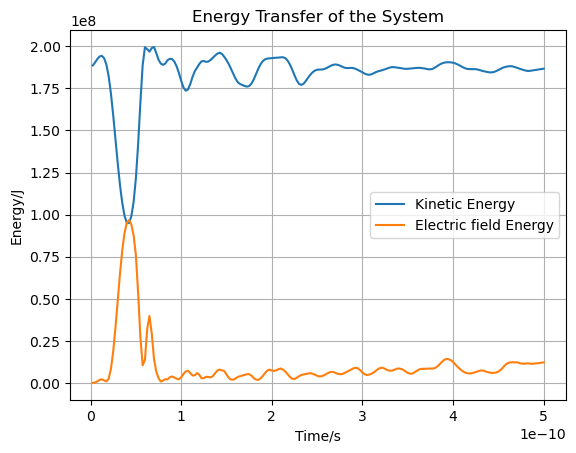

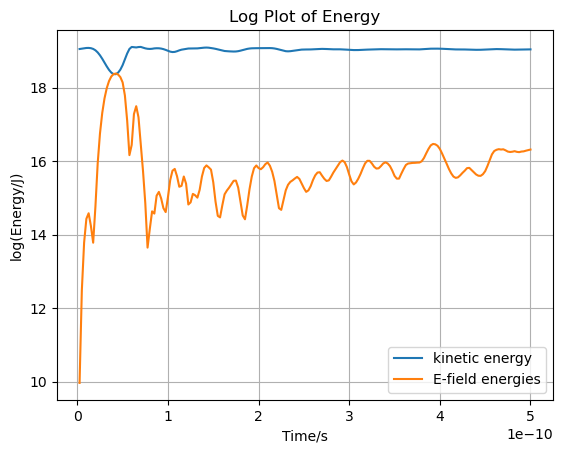

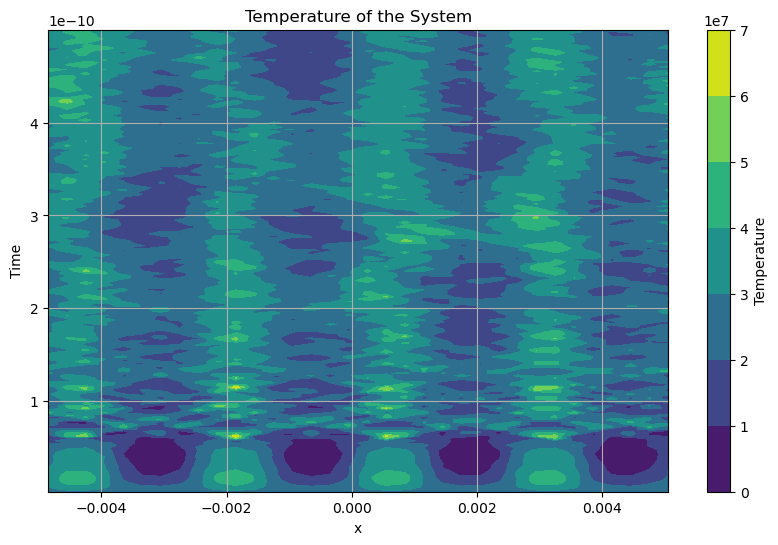

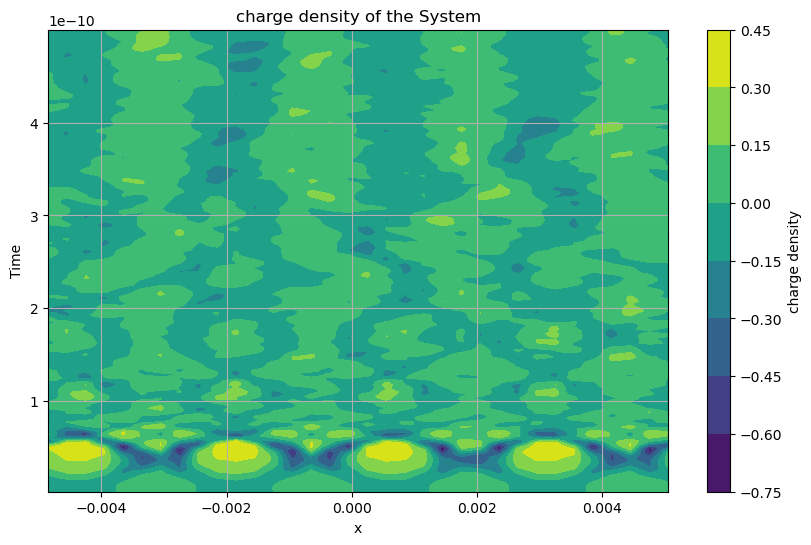

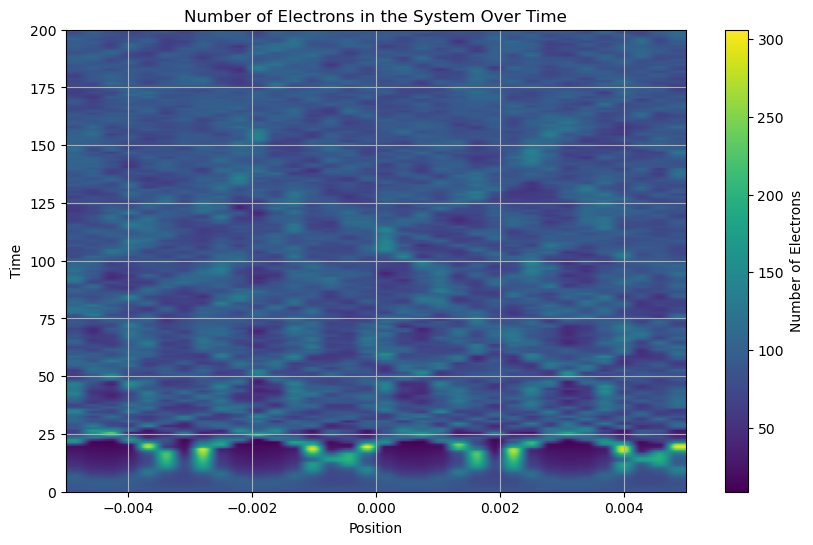

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 27 12:09:32 2023

@author: seanlim
"""

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from simulation_module import simulation
import time

#Creating box and grid
box_size_x = 1e-2
box_size_y = 1e-2
box_size_z = 1e-2
box_size = (box_size_x,box_size_y,box_size_z)

dx=3e-4
grid = jnp.arange(-box_size_x/2+dx/2,box_size_x/2+dx/2,dx)
staggered_grid = grid + dx/2

#Creating particle ICs
no_pseudoelectrons = 3000
L= box_size_x
xs = jnp.array([jnp.linspace(-L/2,L/2,no_pseudoelectrons)])
seed = 1701
key = jax.random.PRNGKey(seed)
electron_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
electron_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
electron_xs_array = jnp.transpose(jnp.concatenate((xs,electron_ys,electron_zs)))
#%%
'Electron-electron stream with stationary ions'
ion_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
ion_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
ion_xs_array = jnp.transpose(jnp.concatenate((xs,ion_ys,ion_zs)))

particle_xs_array = jnp.concatenate((electron_xs_array,ion_xs_array))
no_pseudoparticles = len(particle_xs_array)

alternating_ones = (-1)**jnp.array(range(0,no_pseudoelectrons))
v0=0.5e8
electron_vxs = v0*alternating_ones
ion_vxs = jnp.zeros(no_pseudoelectrons)
vxs = jnp.concatenate((electron_vxs,ion_vxs))
vys = jnp.zeros(no_pseudoparticles)
vzs = jnp.zeros(no_pseudoparticles)
particle_vs_array = jnp.transpose(jnp.concatenate((jnp.array([vxs]),jnp.array([vys]),jnp.array([vzs]))))

weight = 1e13
q_es = -1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
q_ps = 1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
qs = jnp.concatenate((q_es,q_ps))
m_es = 9.1e-31*weight*jnp.ones(shape=(no_pseudoelectrons,1))
m_ps = 1.67e-27*weight*jnp.ones(shape=(no_pseudoelectrons,1))
ms = jnp.concatenate((m_es,m_ps))
q_mes = -1.76e11*jnp.ones(shape=(no_pseudoelectrons,1))
q_mps = 9.56e7*jnp.ones(shape=(no_pseudoelectrons,1))
q_ms = jnp.concatenate((q_mes,q_mps))

particles = (particle_xs_array,particle_vs_array,qs,ms,q_ms,
             (no_pseudoelectrons,no_pseudoparticles-no_pseudoelectrons),
             weight)

#Creating initial fields
E_fields = jnp.zeros(shape=(len(grid),3))
B_fields = jnp.zeros(shape=(len(grid),3))

fields = (E_fields,B_fields)

ICs = (box_size,particles,fields)

x=[0.5,2513]
A=x[0]
k=x[1]
ext_E = jnp.zeros(shape=(len(grid),3))
for i in range(len(grid)):
    ext_E = ext_E.at[i].set(jnp.array(
        [-weight*1.6e-19*no_pseudoelectrons*A*jnp.cos(k*(grid[i]+dx/2))/(k*L*8.85e-12),0,0])
        )
        
ext_B = jnp.zeros(shape=(len(grid),3))
ext_fields = (ext_E,ext_B)
#%%
#Simulation
dt = dx/(2*3e8)
steps_per_snapshots=5
total_steps=1000

start = time.perf_counter()
Data = simulation(steps_per_snapshots,total_steps,ICs,ext_fields,dx,dt,(0,0,0,0))
end = time.perf_counter()
print('Simulation complete, time taken: '+str(end-start)+'s')

t = jnp.array(Data['Time'])
#%%
xs_over_time = jnp.array(Data['Positions'])
vs_over_time = jnp.array(Data['Velocities'])

ke_over_time = jnp.array(Data['Kinetic Energy'])
E_field_energy_density = jnp.array(Data['E-field Energy'])
E_field_energy = jnp.sum(E_field_energy_density,axis=1)
plt.title('Energy Transfer of the System')
plt.ylabel('Energy/J')
plt.xlabel('Time/s')
plt.plot(t,ke_over_time,label='Kinetic Energy')
plt.plot(t,E_field_energy,label='Electric field Energy')
plt.grid()
plt.legend()
plt.show()
#%%
plt.title('Log Plot of Energy')
plt.xlabel('Time/s')
plt.ylabel('log(Energy/J)')
plt.plot(t,jnp.log(ke_over_time),label='kinetic energy')
plt.plot(t,jnp.log(E_field_energy),label='E-field energies')
plt.grid()
plt.legend()
plt.show()
Ts_over_time = jnp.array(Data['Temperature'])
# Extracting the shape of the data
time_steps, _, positions = Ts_over_time.shape

# Create a meshgrid for time and position
time = jnp.arange(time_steps)
position = jnp.arange(positions)
time_mesh, position_mesh = jnp.meshgrid(t, grid, indexing='ij')

# Extracting temperature values
temperature_values = Ts_over_time[:, 0, :]

# Plotting the density plot
plt.figure(figsize=(10, 6))
plt.contourf(position_mesh, time_mesh, temperature_values, cmap='viridis')
plt.colorbar(label='Temperature')
plt.title('Temperature of the System')
plt.xlabel('x')
plt.ylabel('Time')
plt.grid(True)
plt.show()

density = jnp.array(Data['Charge Densities'])

# Plotting the density plot
plt.figure(figsize=(10, 6))
plt.contourf(position_mesh, time_mesh, density, cmap='viridis')
plt.colorbar(label='charge density')
plt.title('charge density of the System')
plt.xlabel('x')
plt.ylabel('Time')
plt.grid(True)
plt.show()

xs_over_time = jnp.array(Data['Positions'])
# Define the bin edges for histogram (based on box size and grid size)
bin_edges = jnp.linspace(-box_size_x/2,box_size_x/2,len(grid)+1)

# Initialize an array to store the histogram counts over time
hist_counts = jnp.zeros((time_steps, len(grid)))

# Calculate the histogram for each time step
for t in range(time_steps):
    counts, _ = jnp.histogram(xs_over_time[t, :no_pseudoelectrons, 0], bins=bin_edges)
    hist_counts = hist_counts.at[t].set(counts)

# Plotting the density plot with time on the y-axis
plt.figure(figsize=(10, 6))
plt.imshow(hist_counts, aspect='auto', cmap='viridis', origin='lower',
           extent=[-box_size_x / 2, box_size_x / 2, 0, time_steps])
plt.colorbar(label='Number of Electrons')
plt.title('Number of Electrons in the System Over Time')
plt.xlabel('Position')
plt.ylabel('Time')
plt.grid(True)
plt.show()
plt.show()

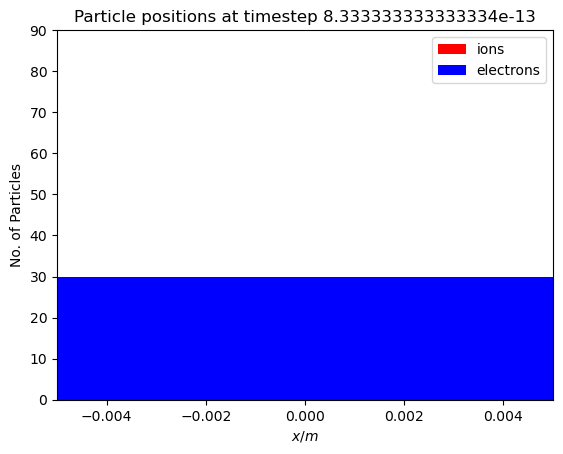

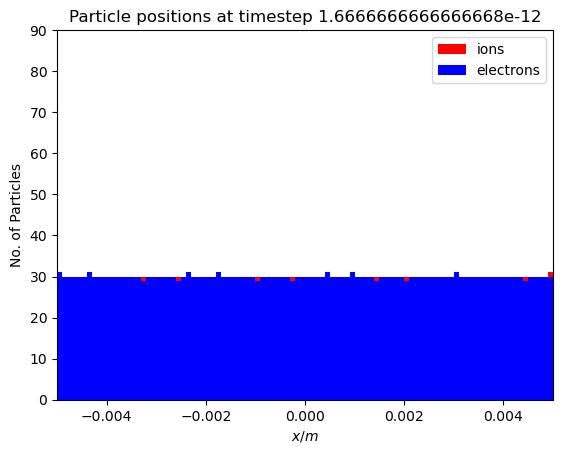

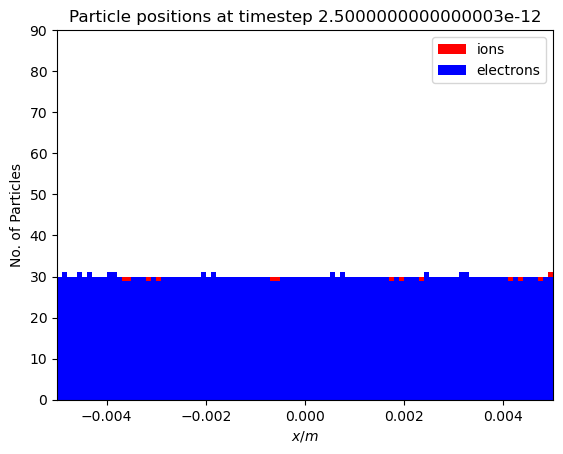

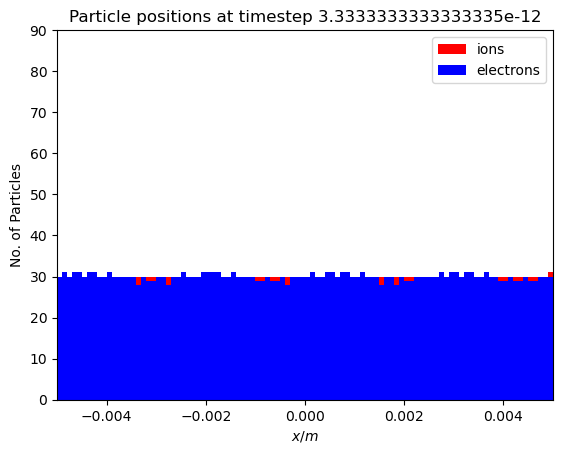

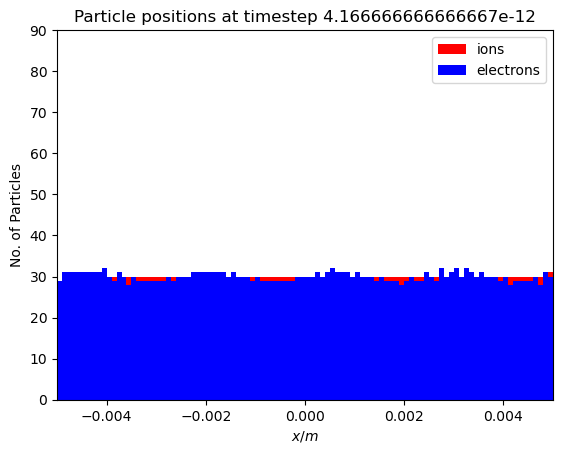

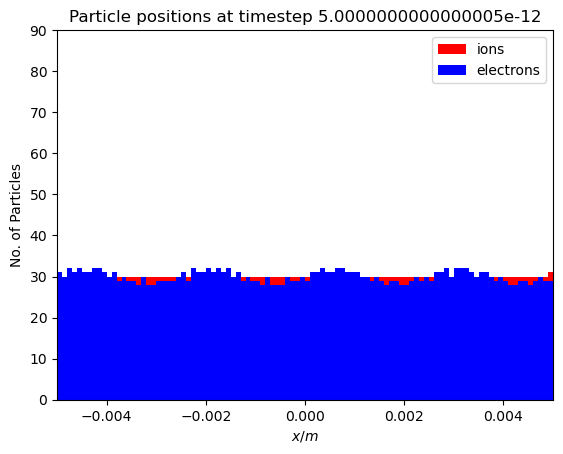

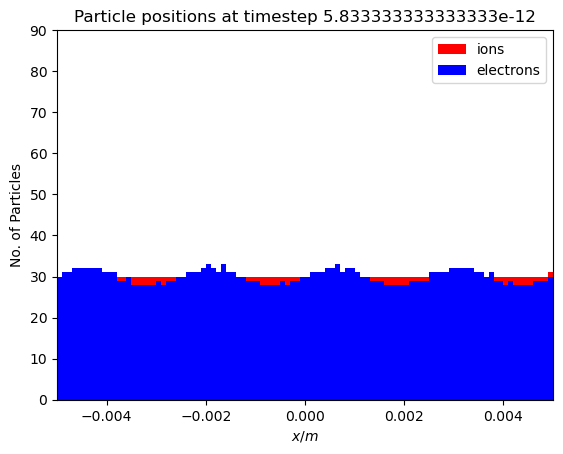

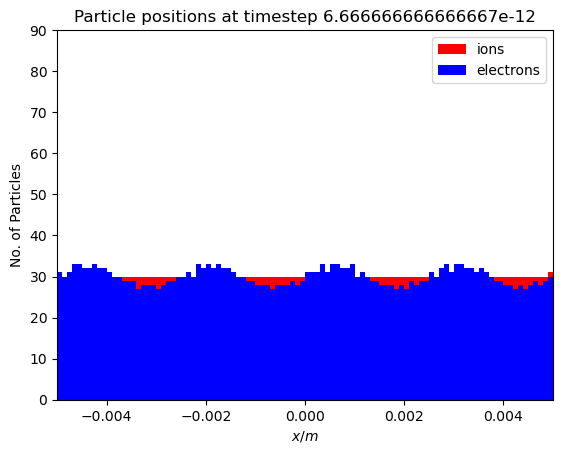

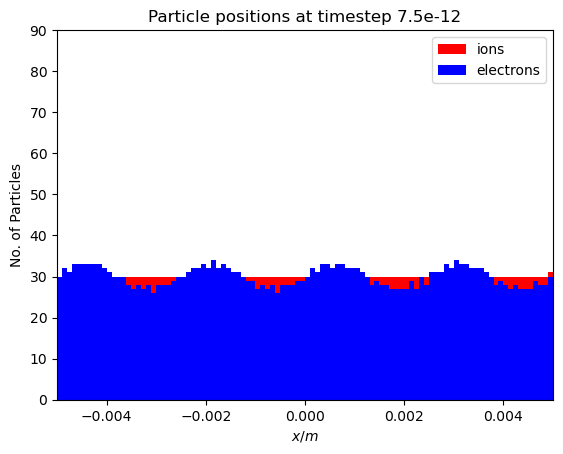

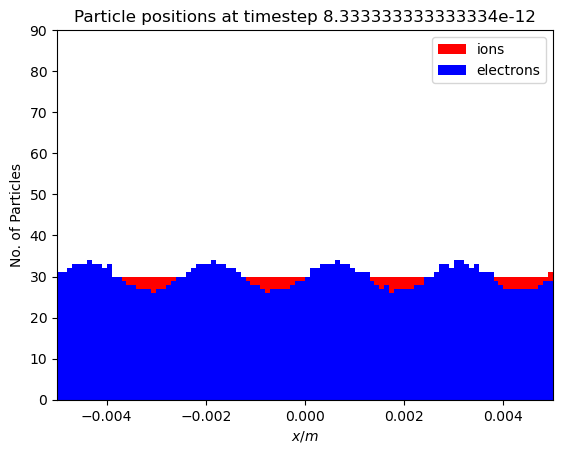

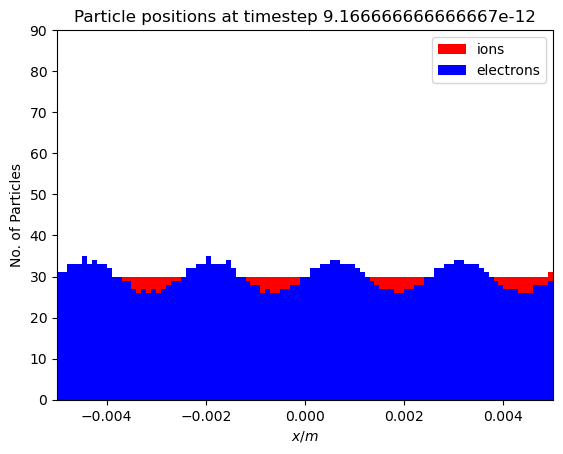

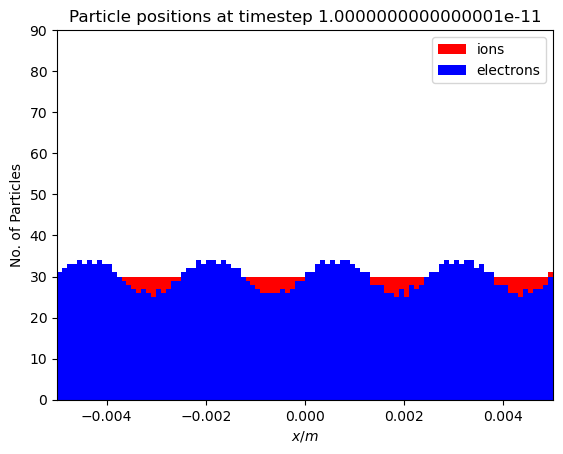

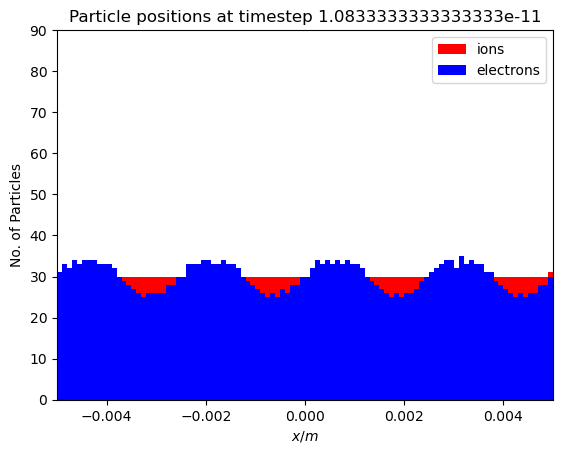

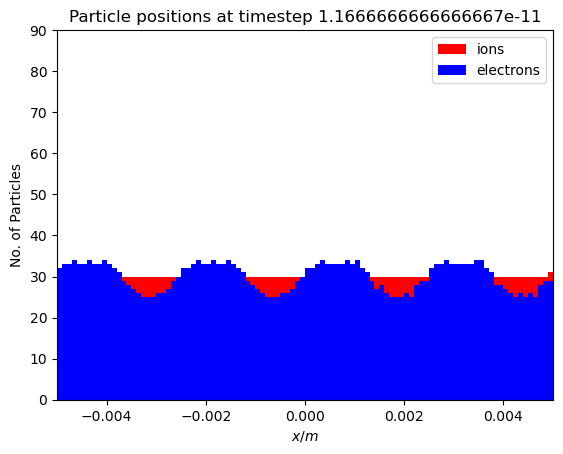

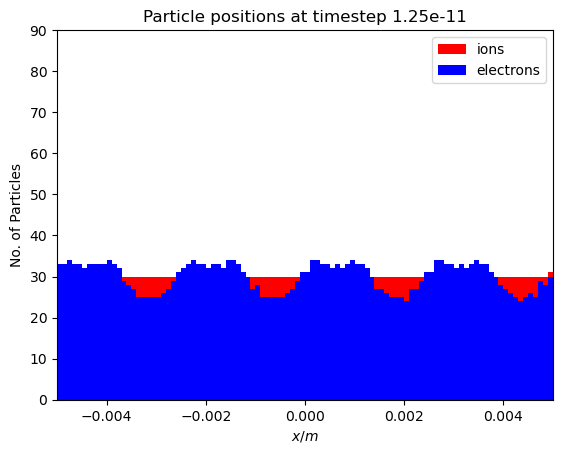

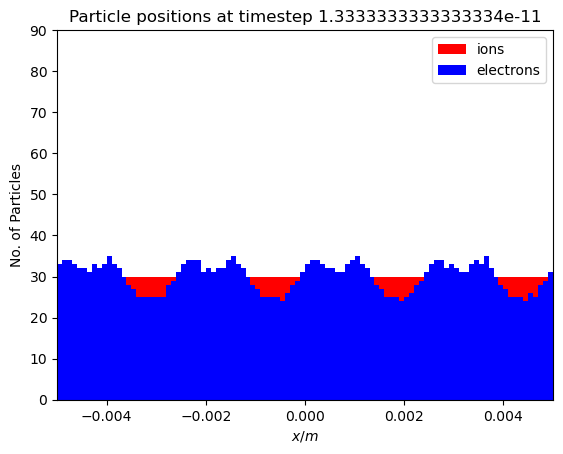

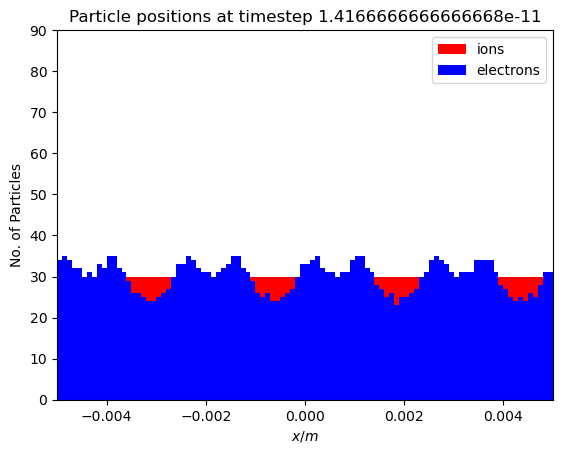

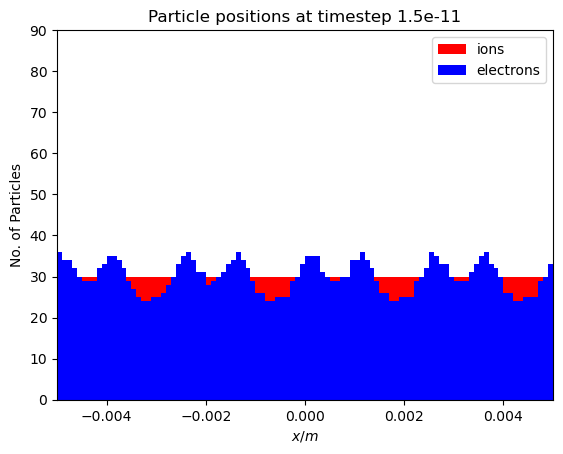

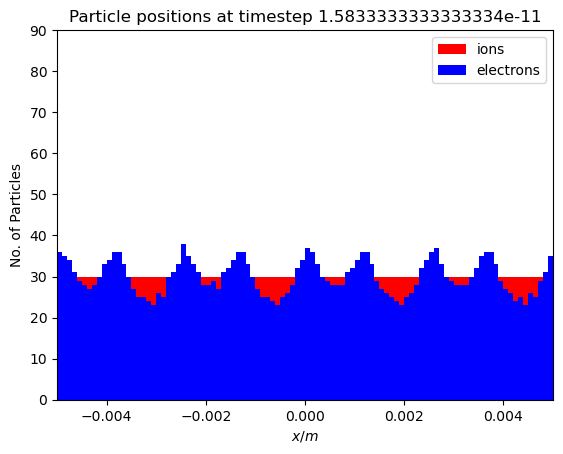

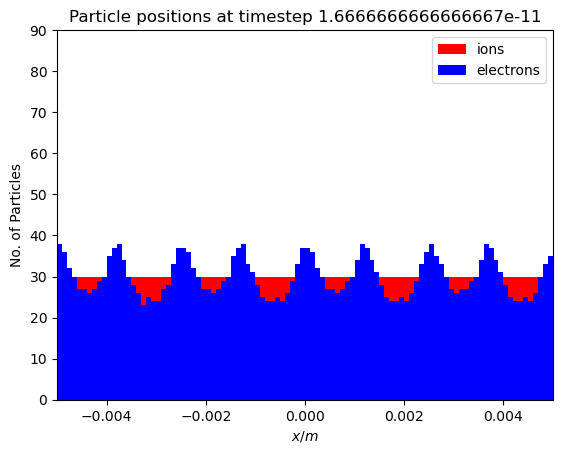

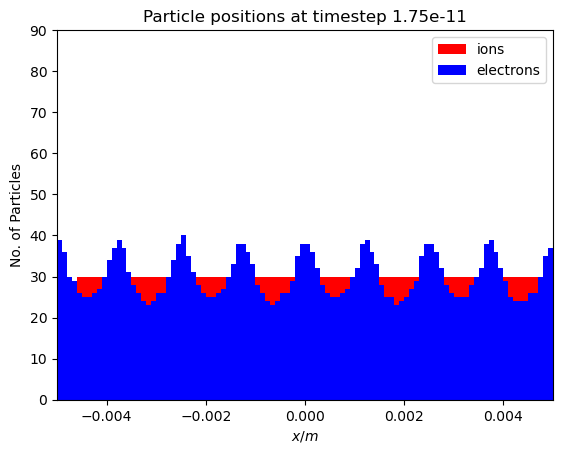

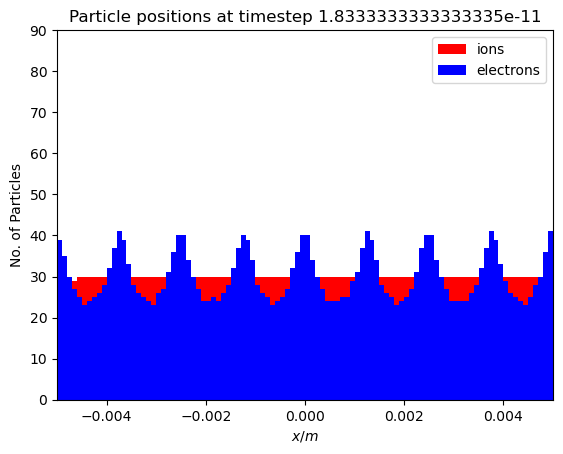

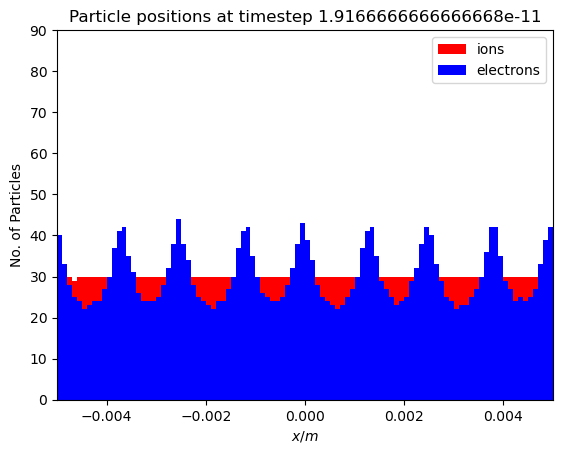

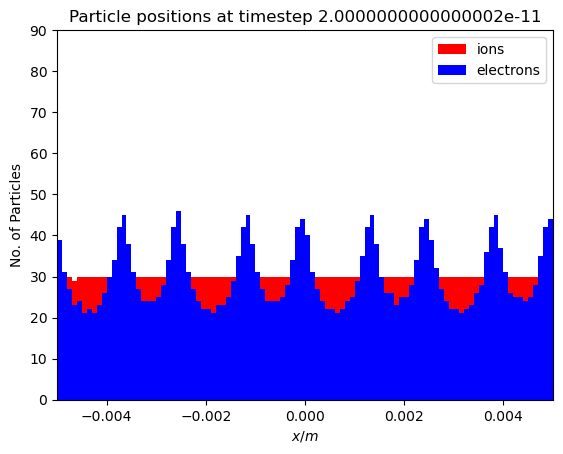

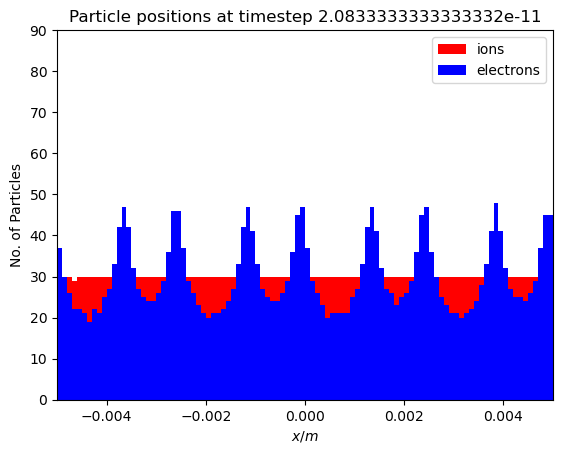

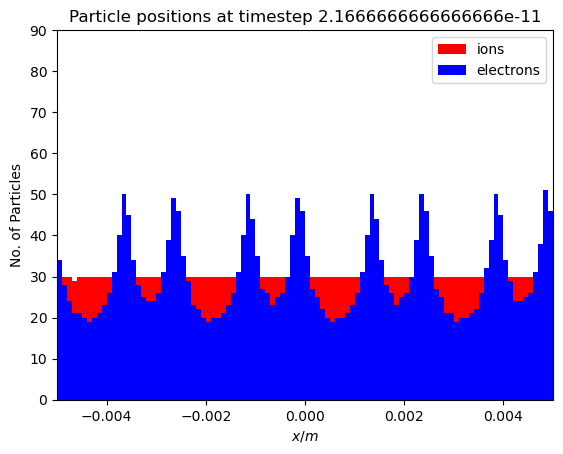

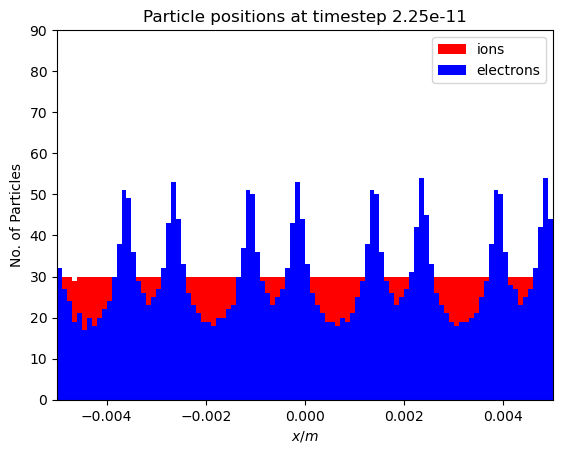

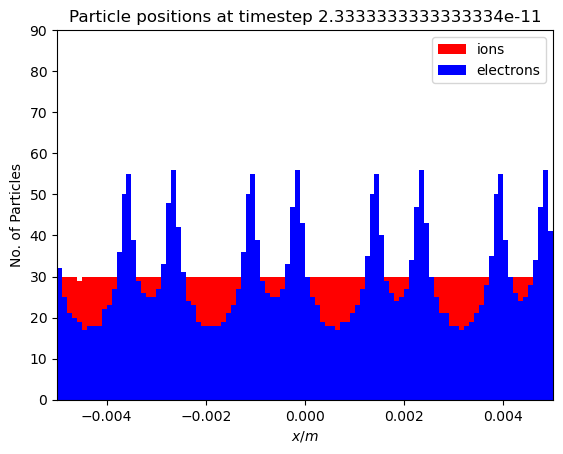

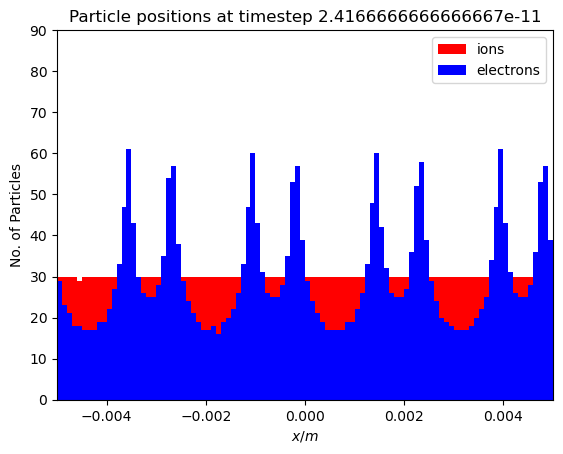

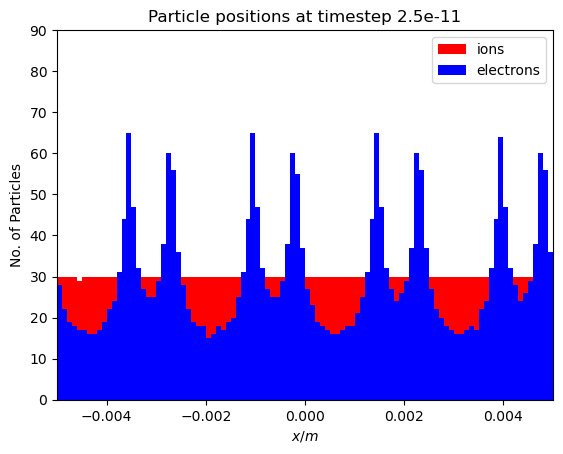

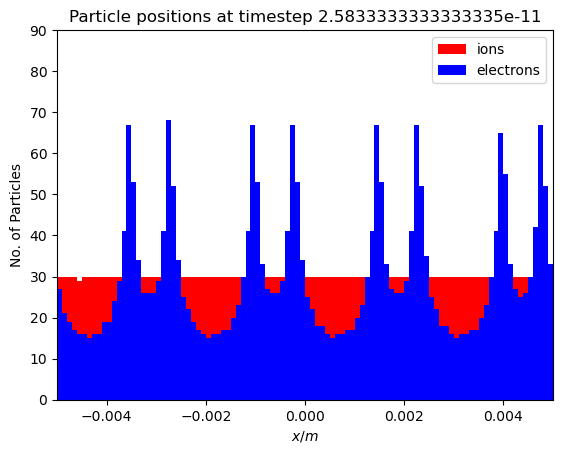

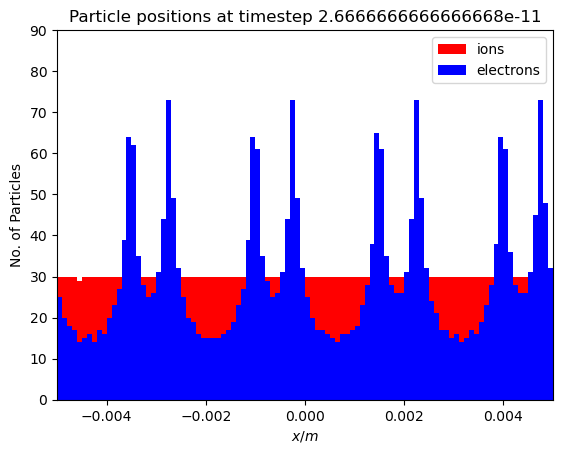

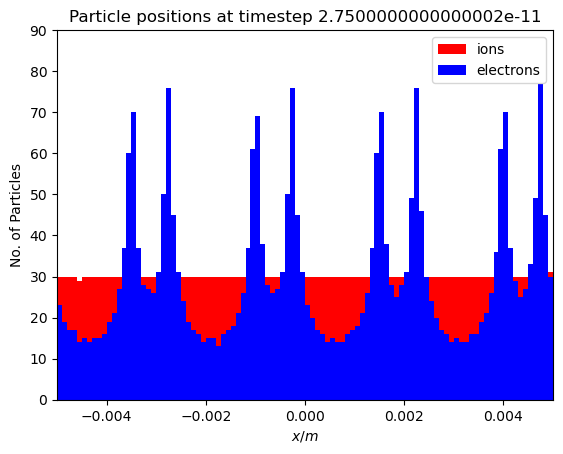

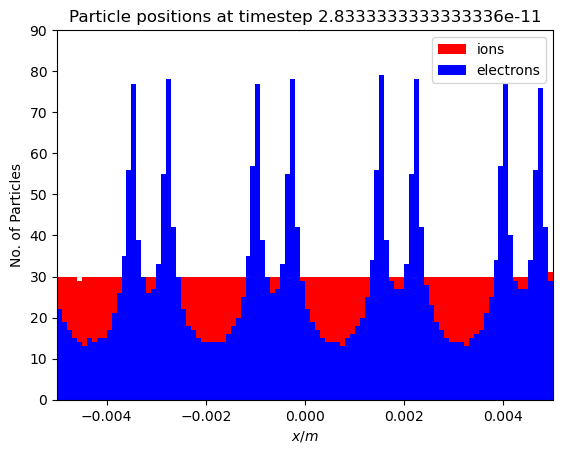

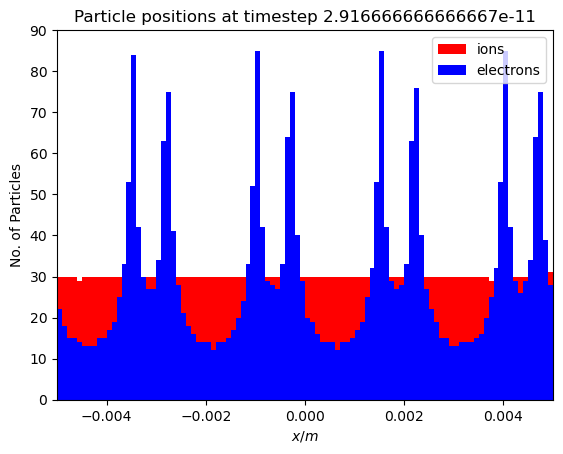

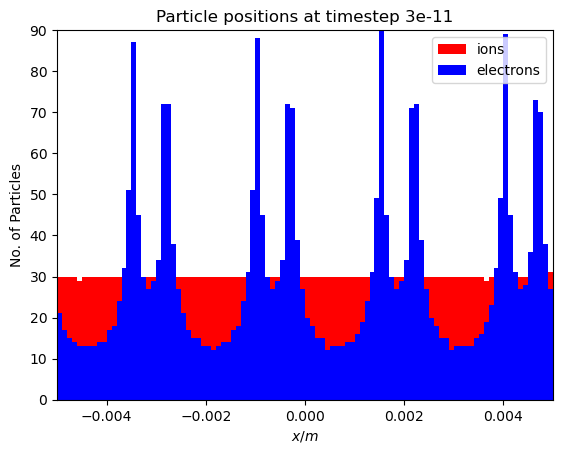

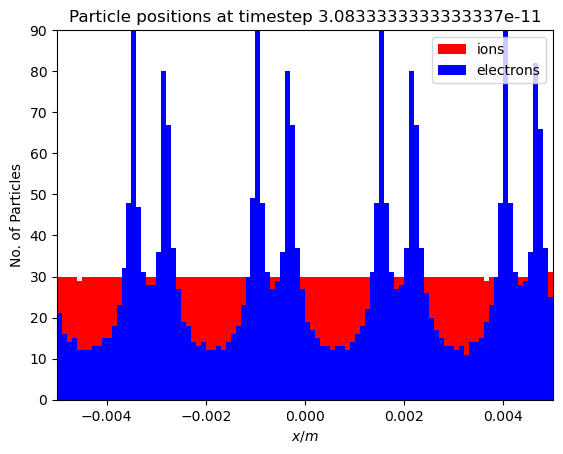

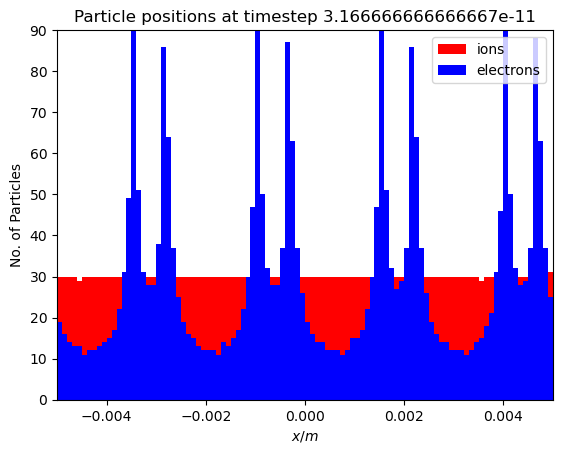

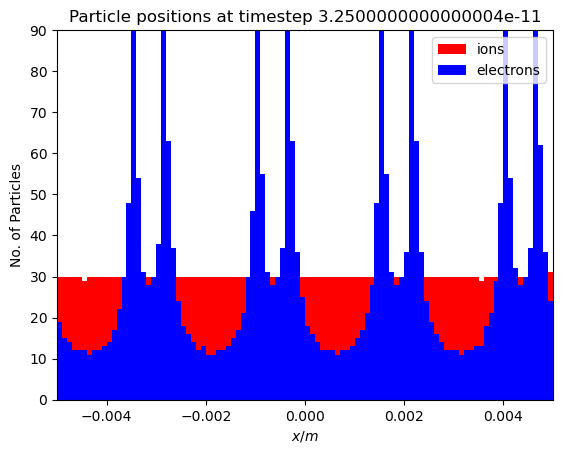

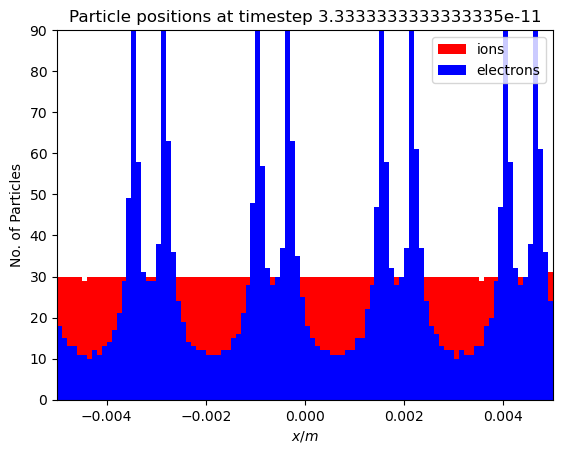

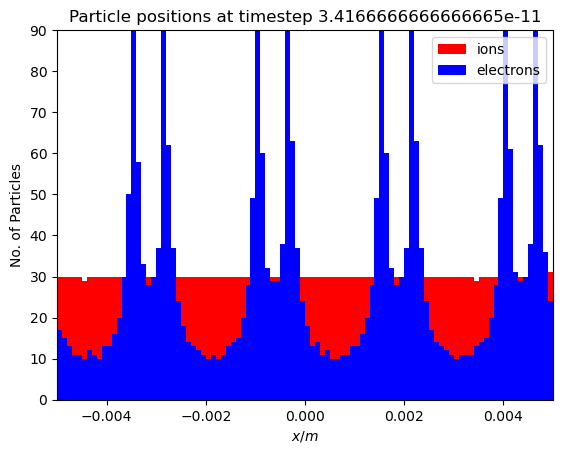

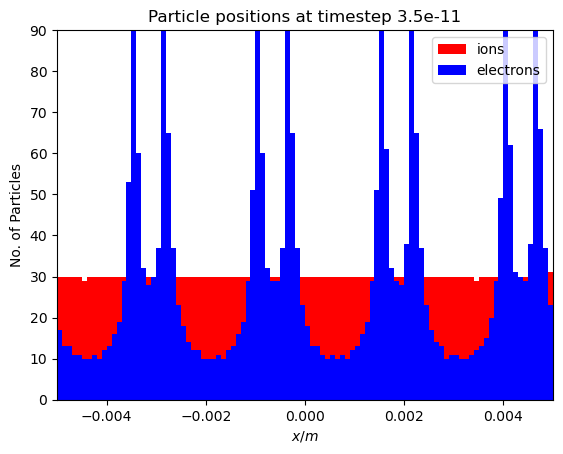

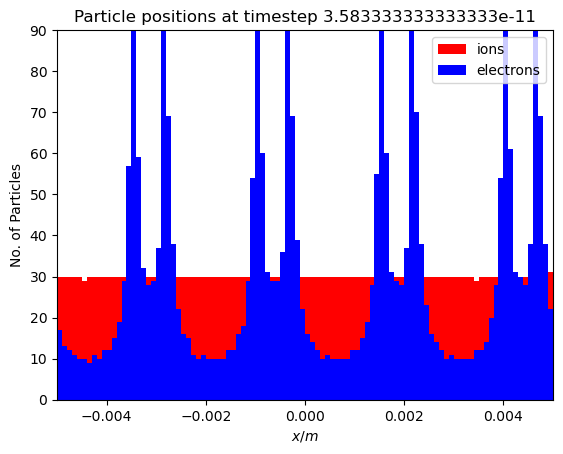

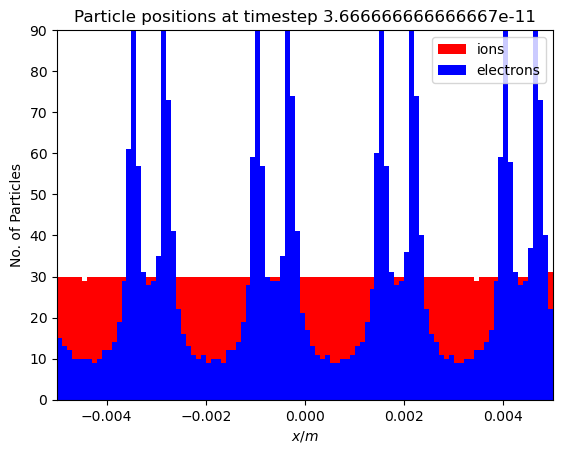

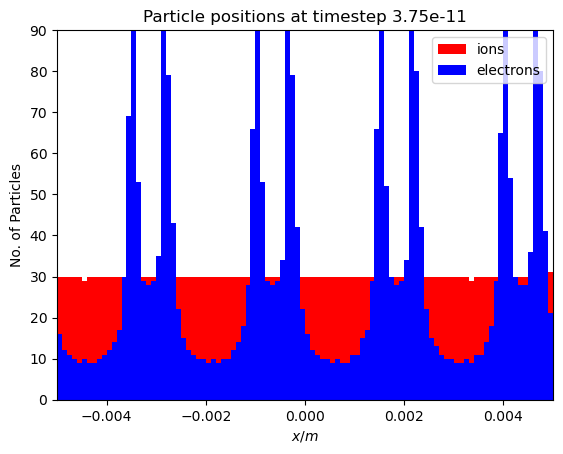

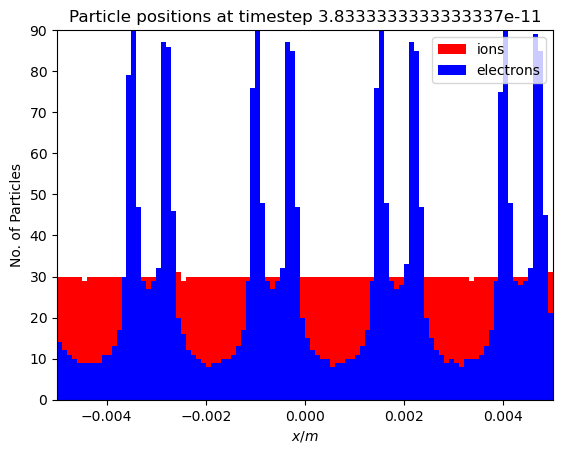

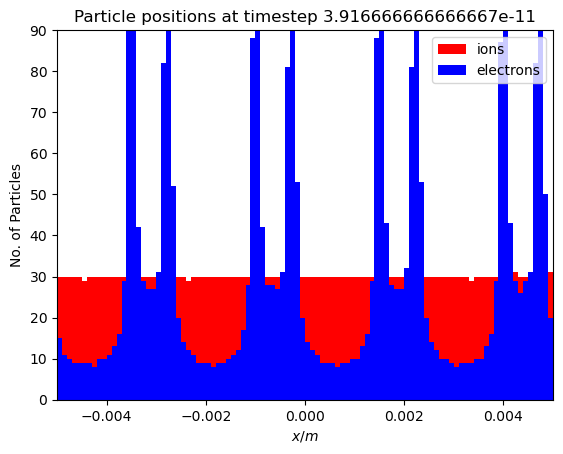

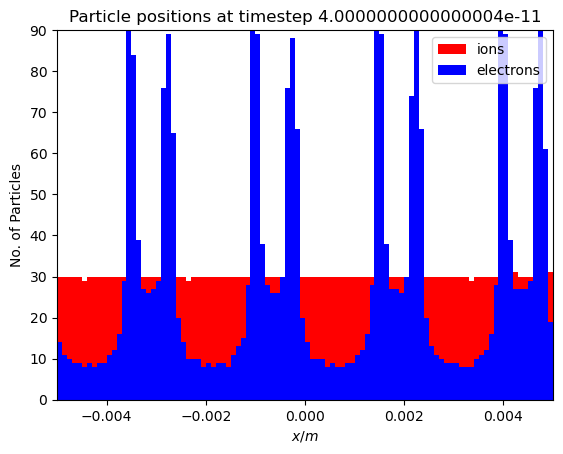

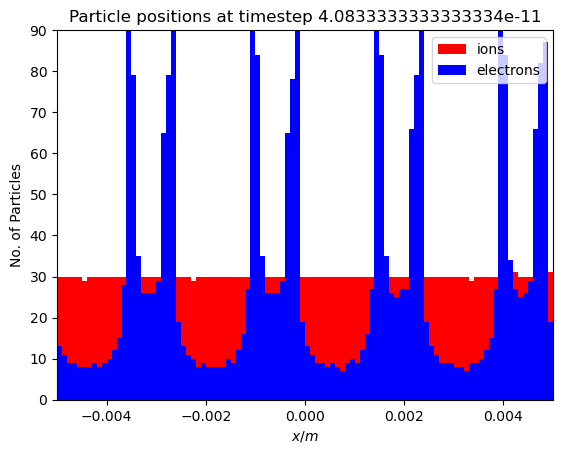

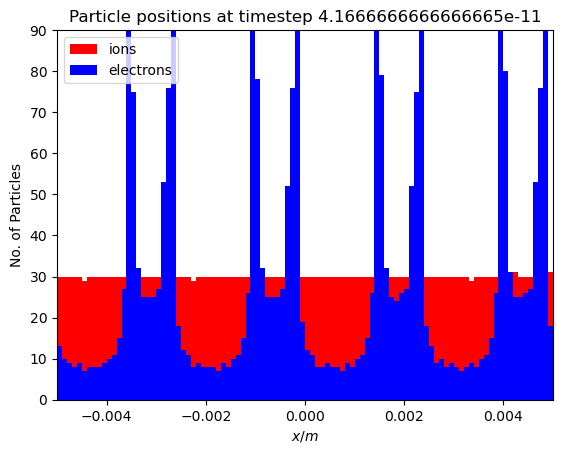

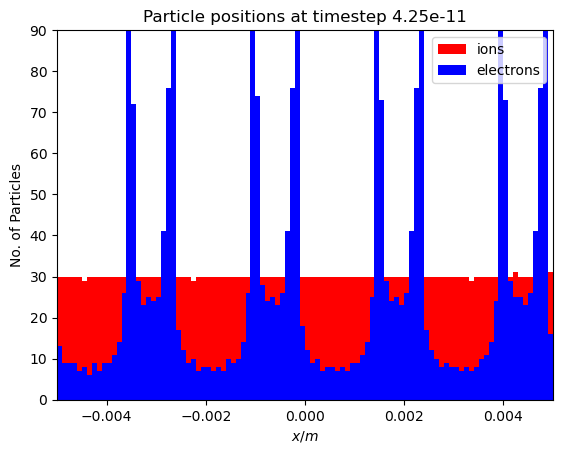

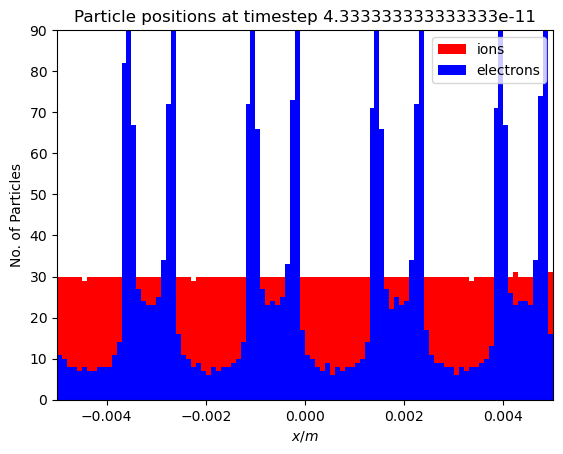

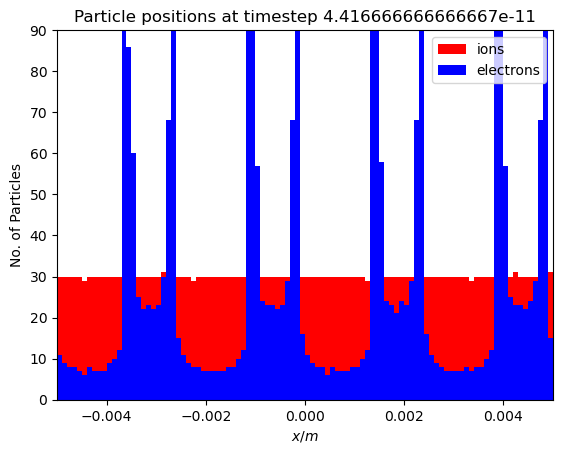

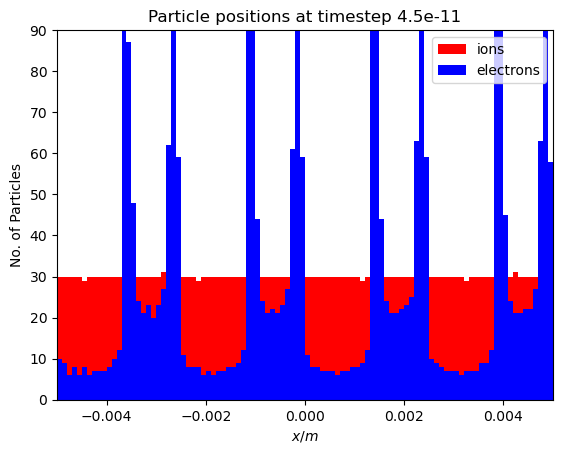

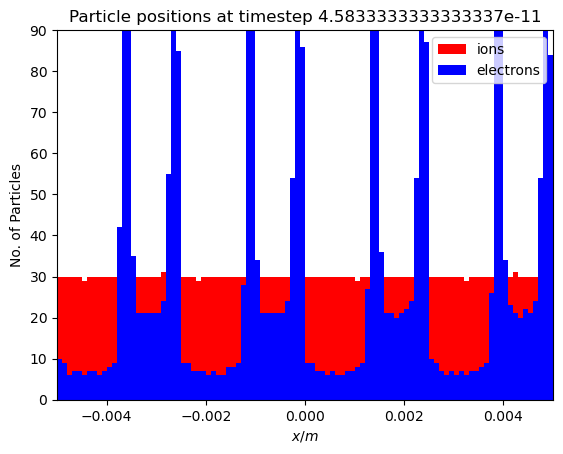

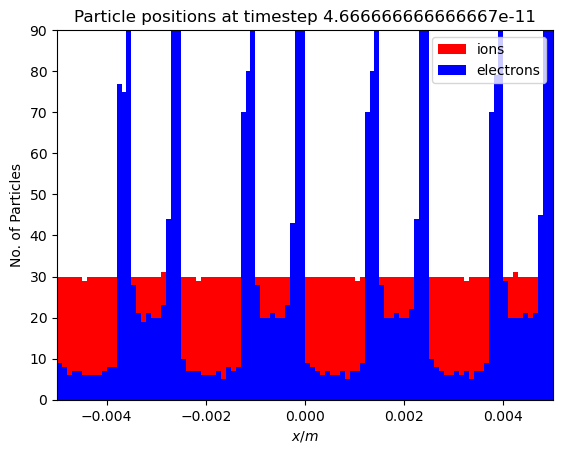

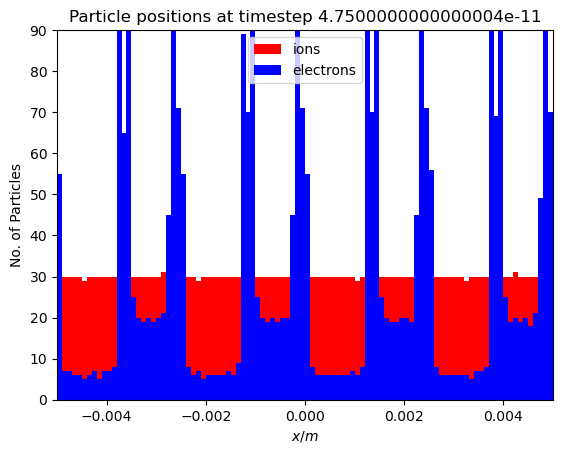

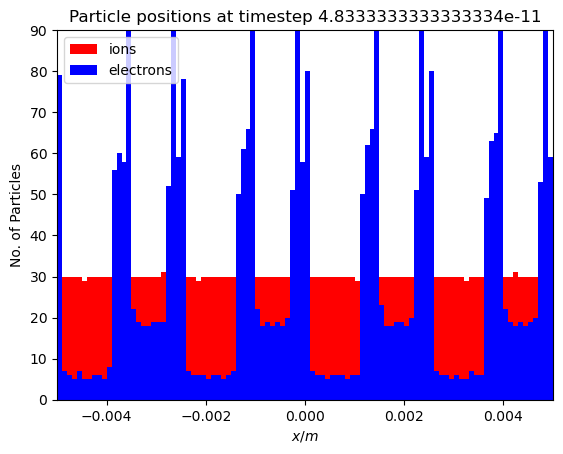

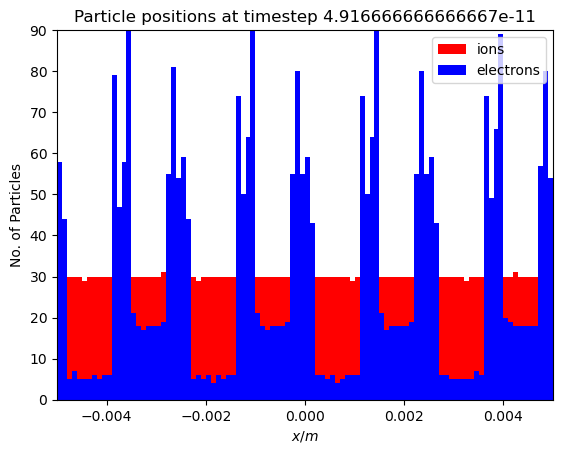

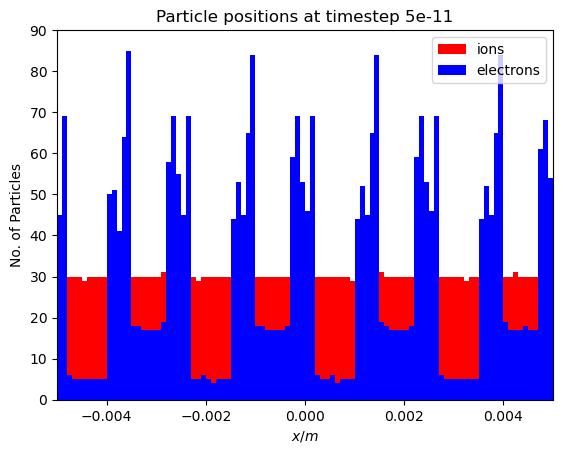

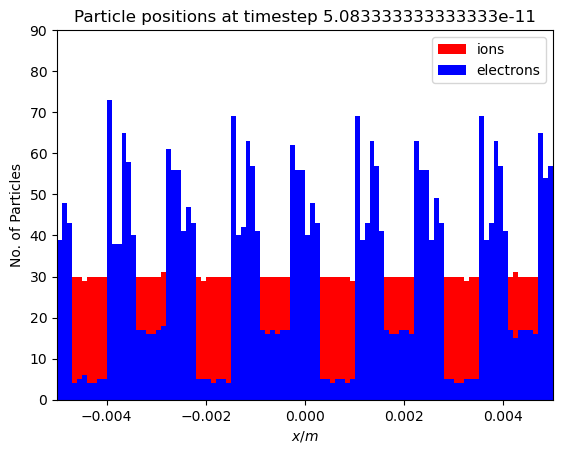

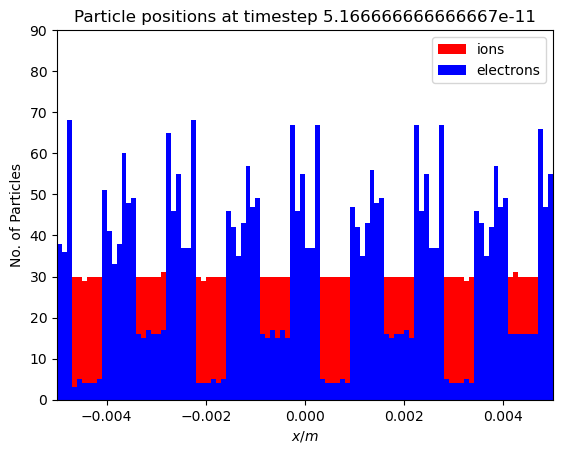

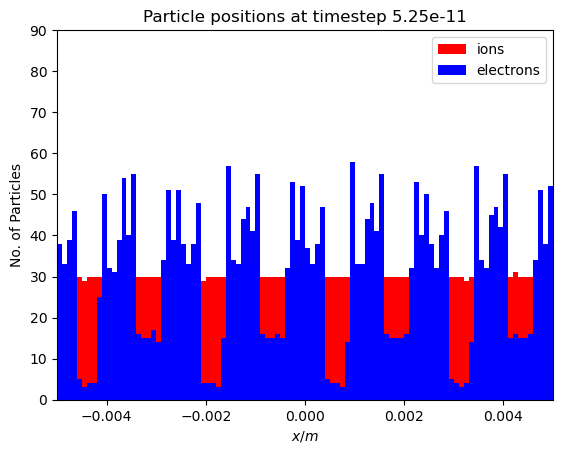

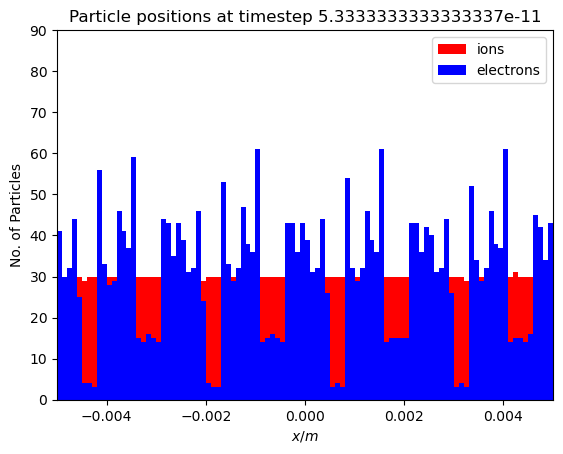

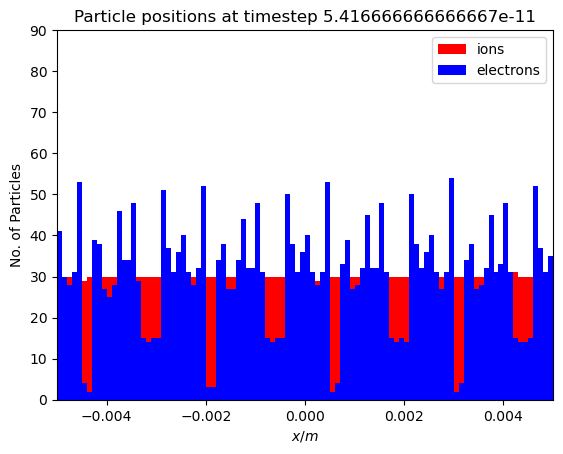

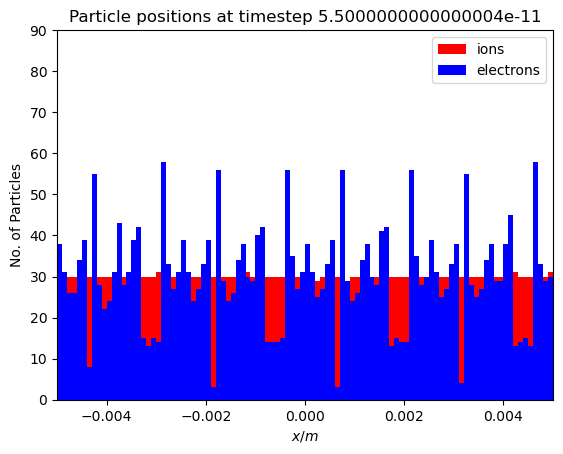

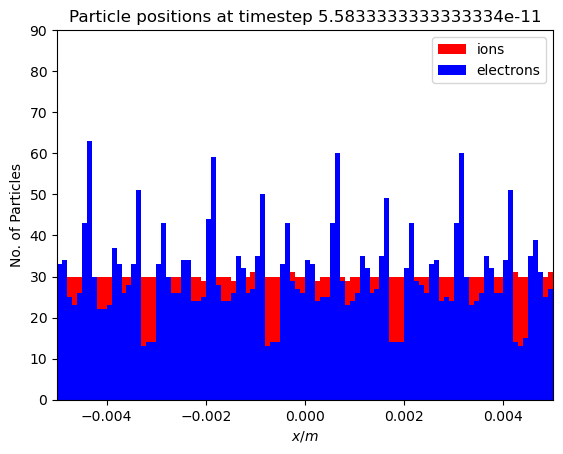

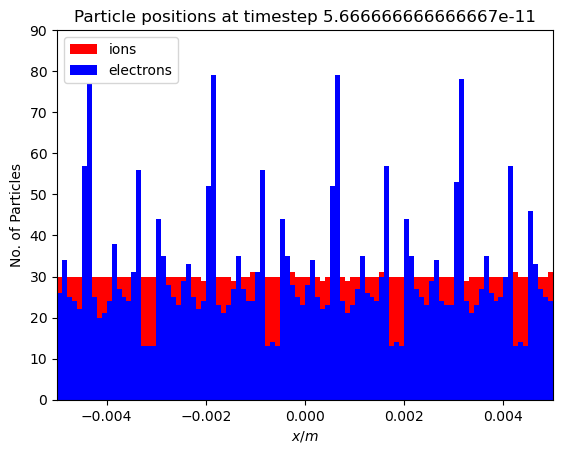

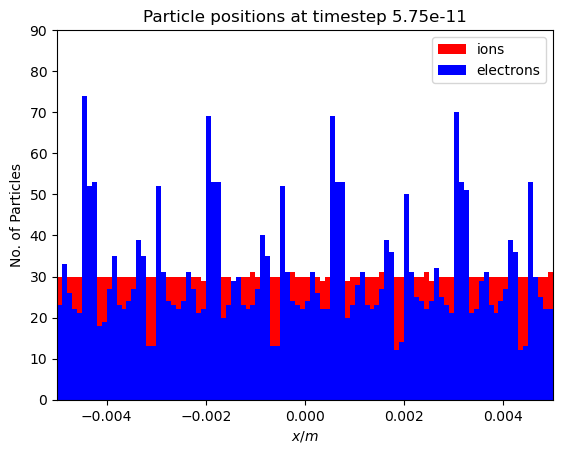

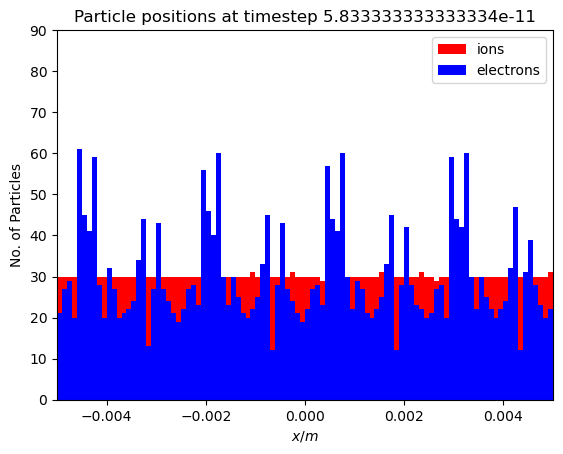

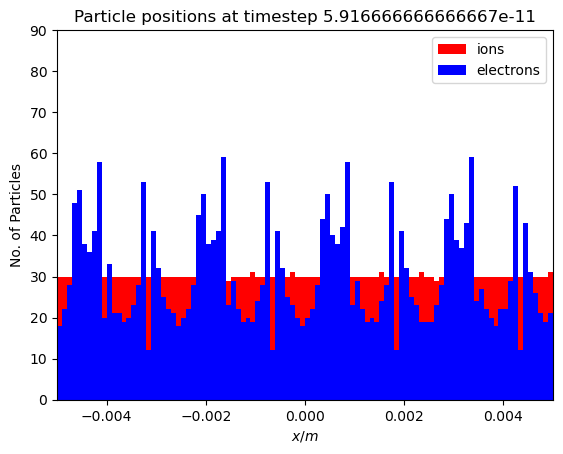

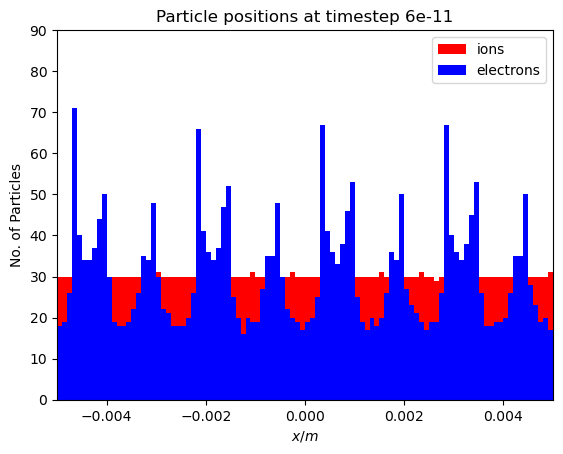

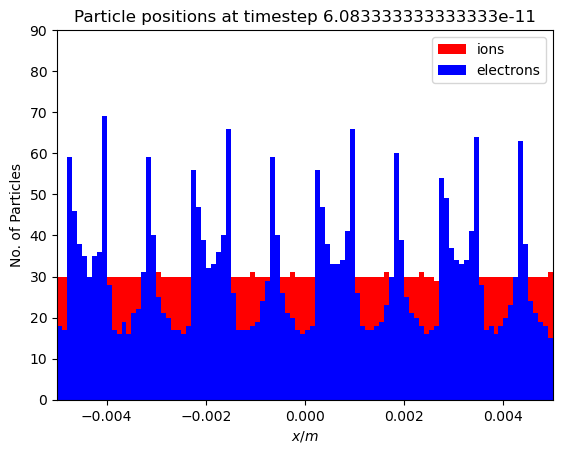

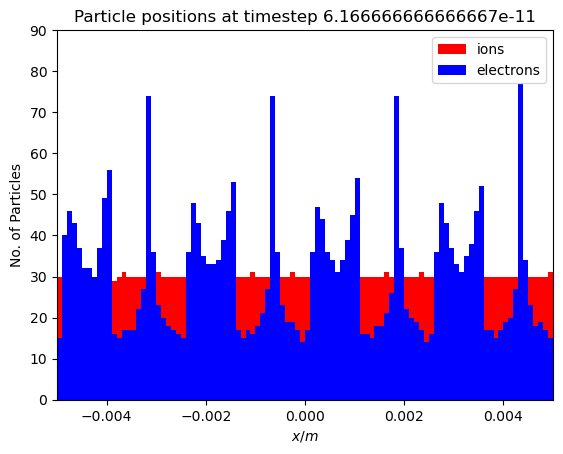

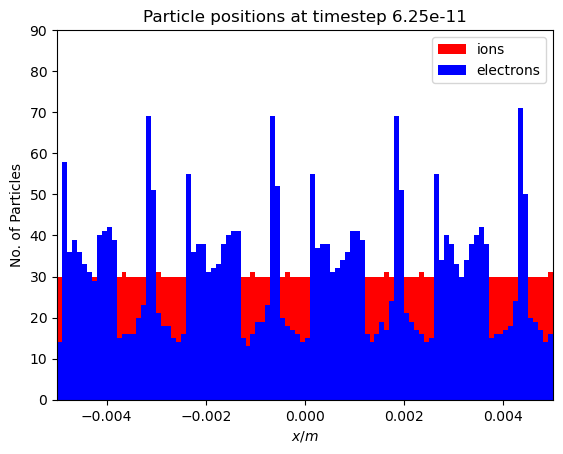

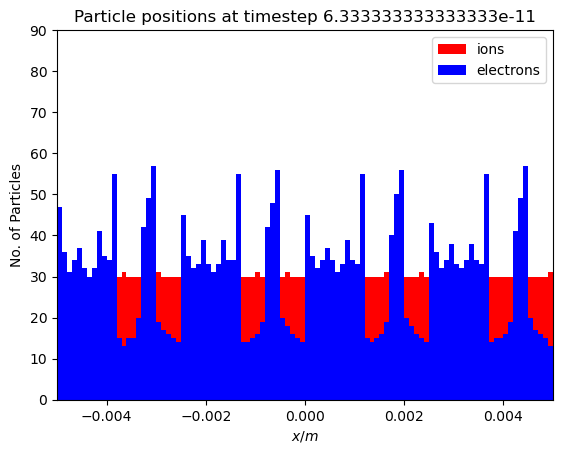

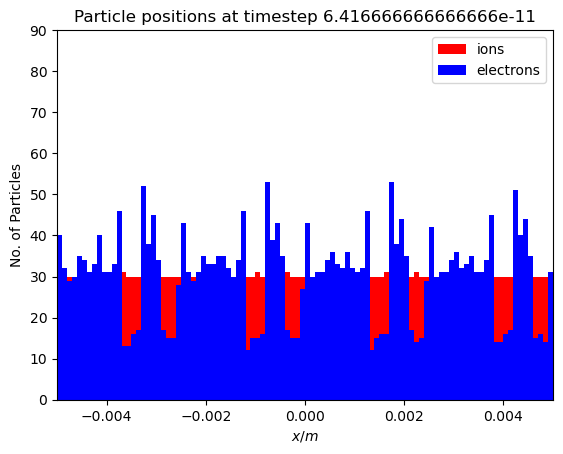

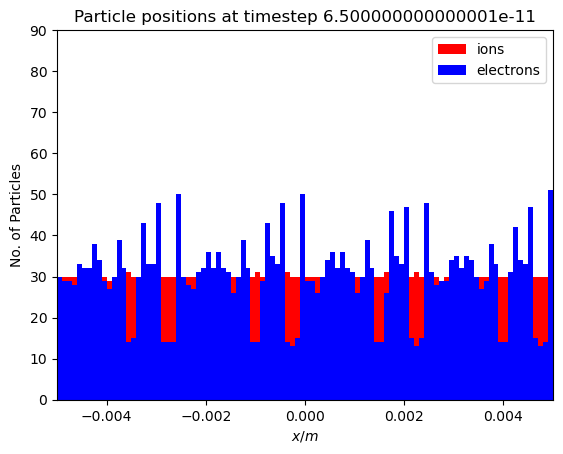

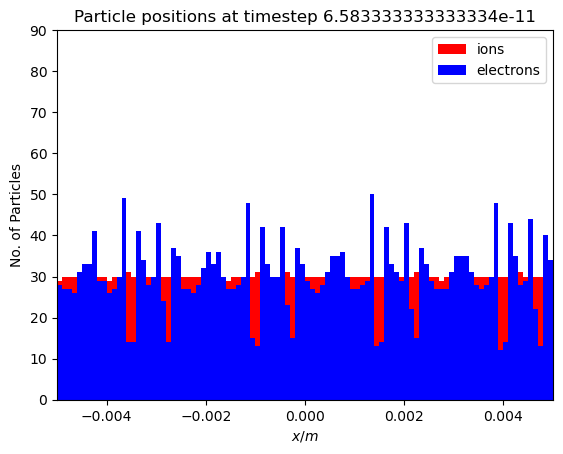

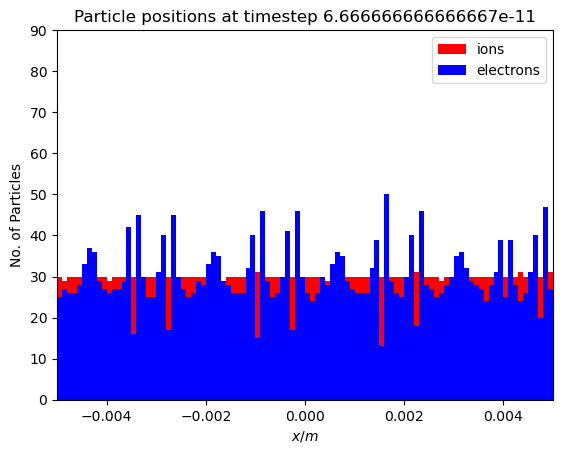

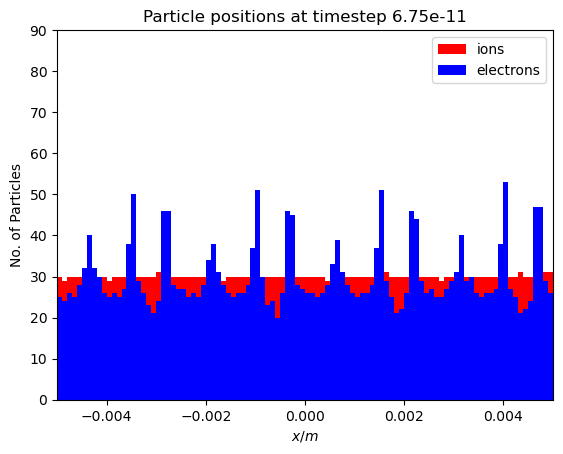

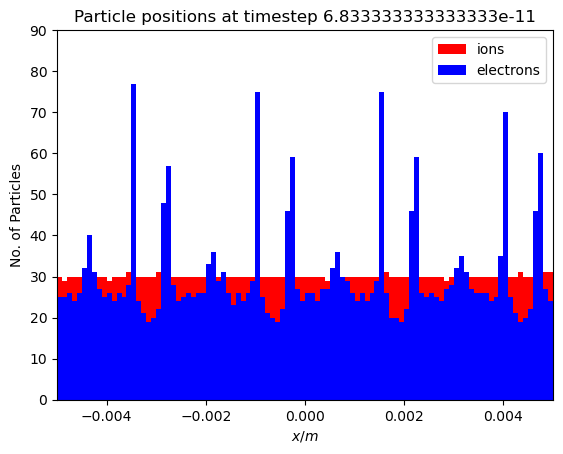

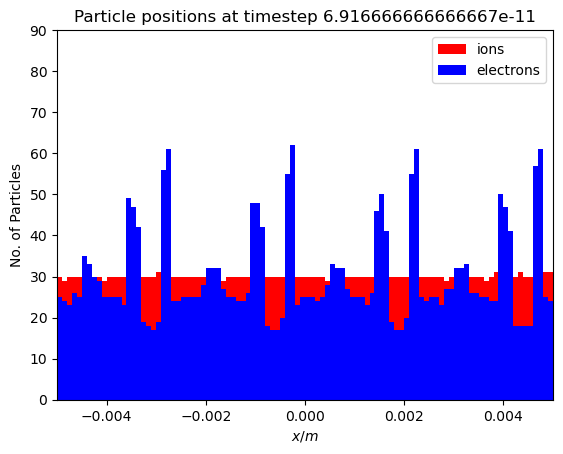

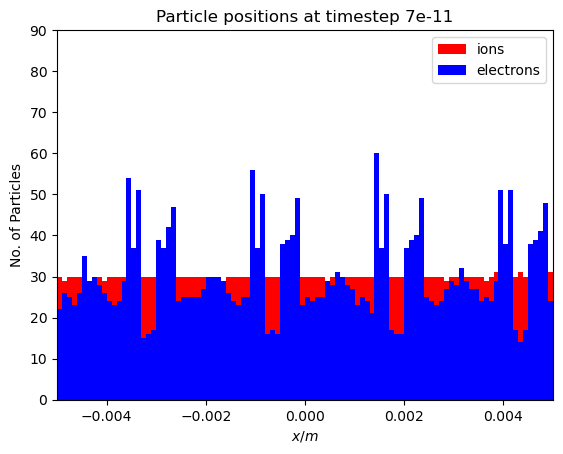

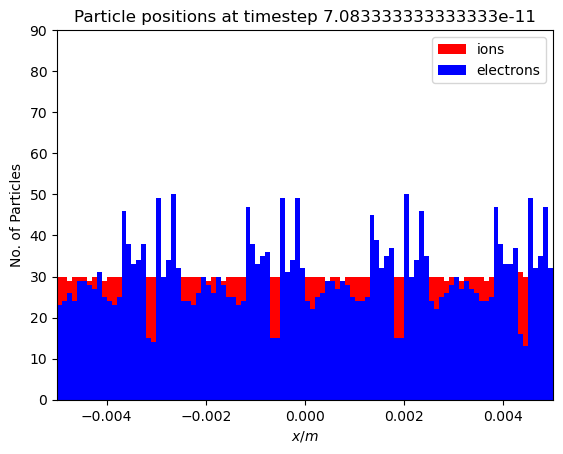

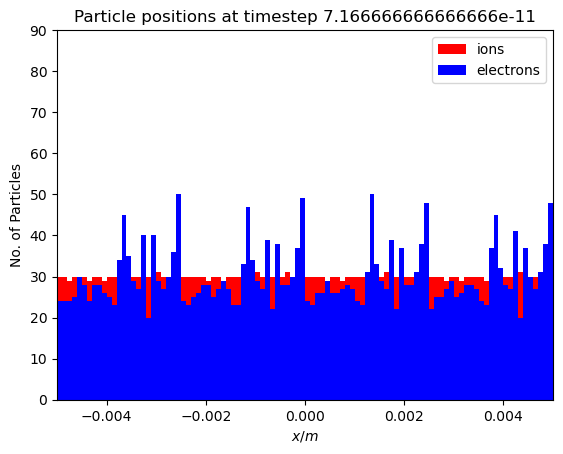

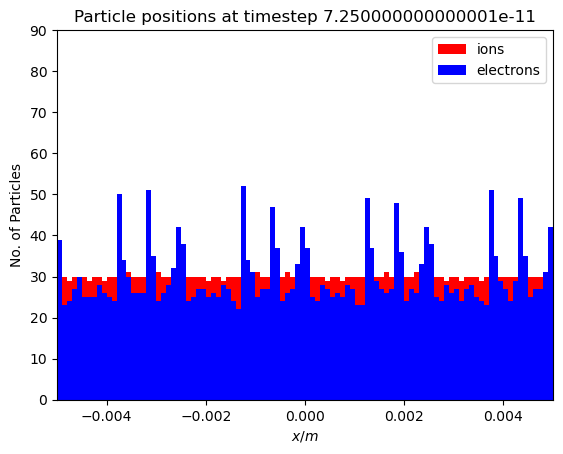

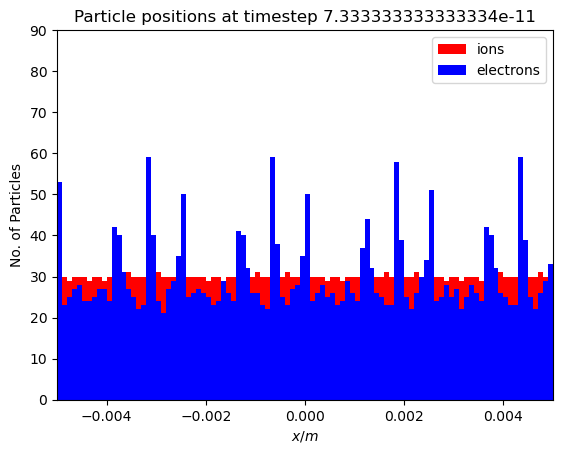

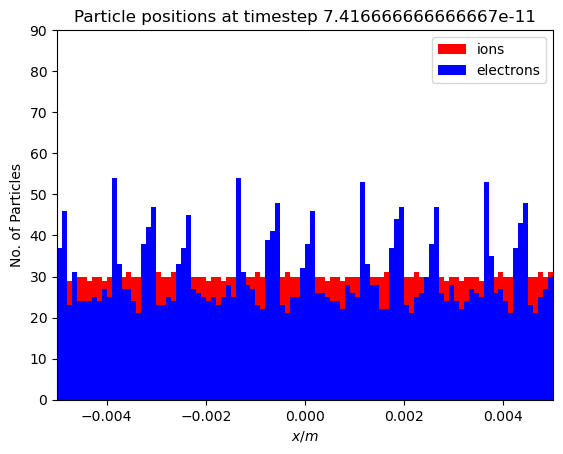

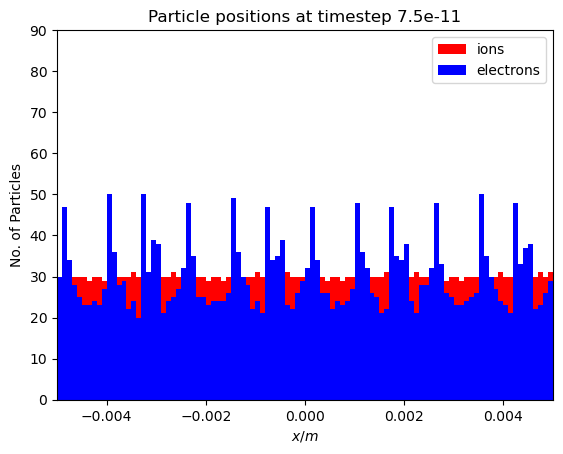

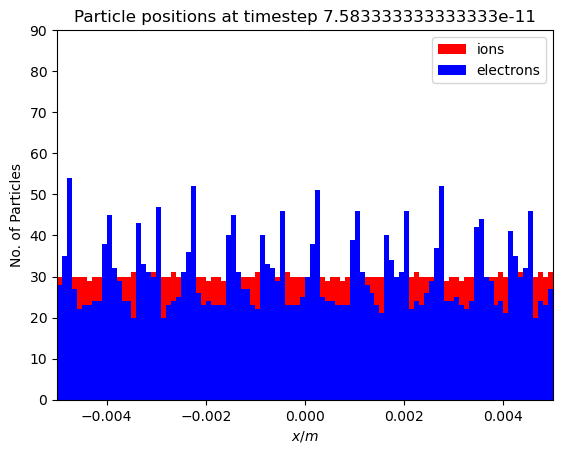

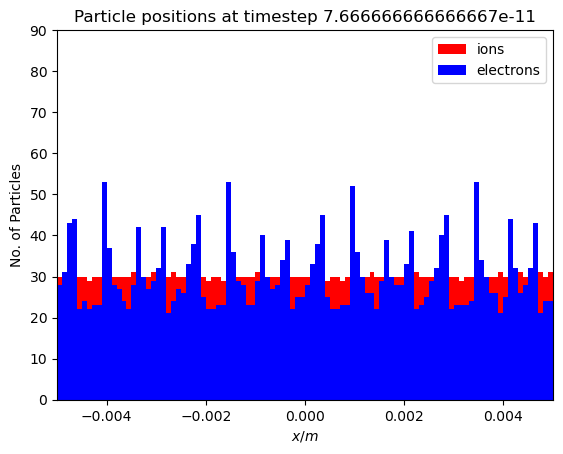

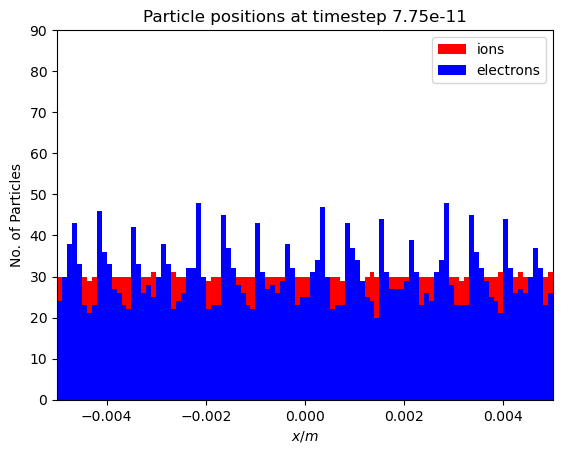

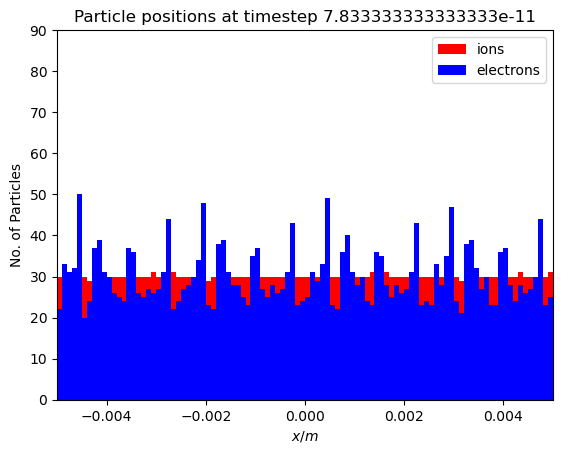

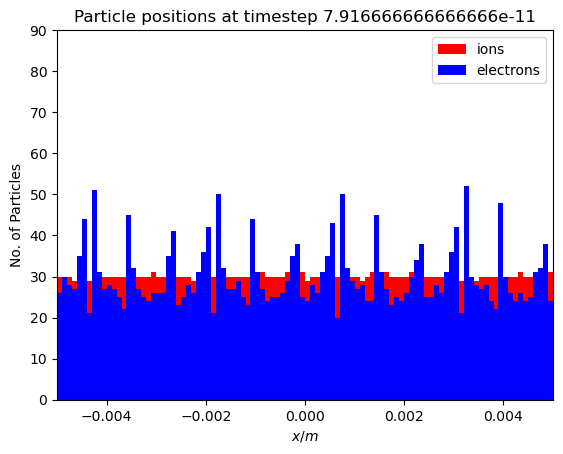

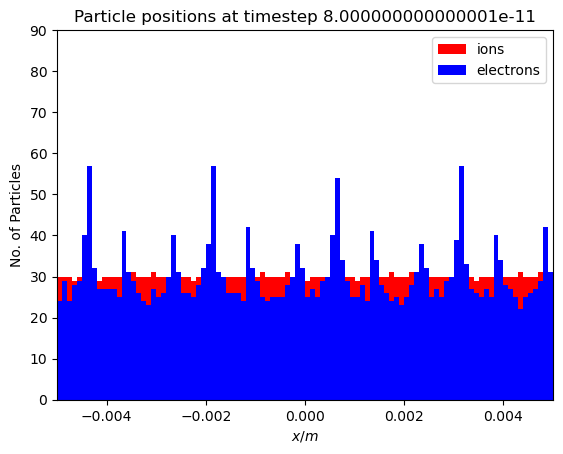

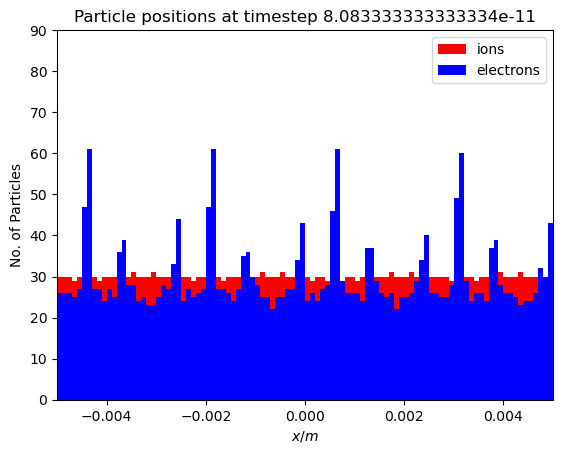

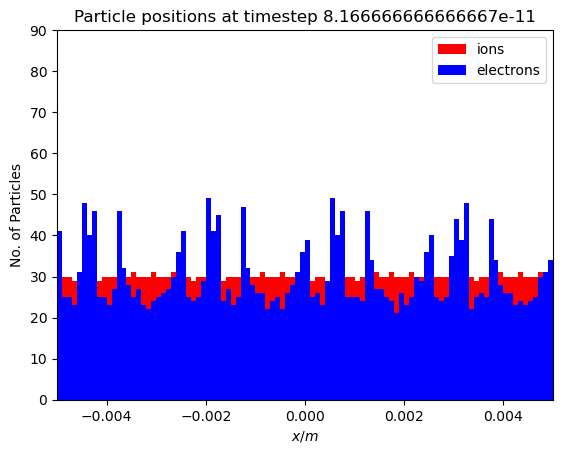

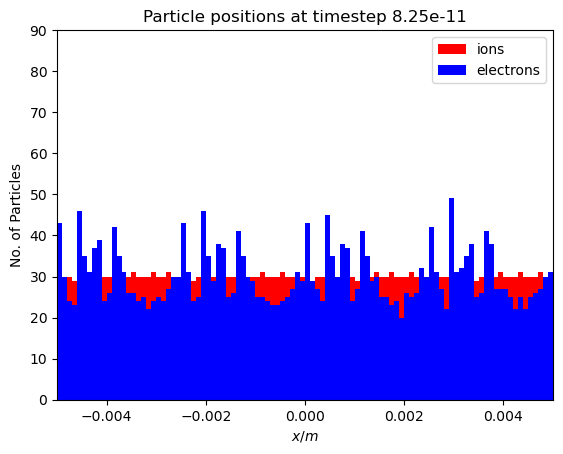

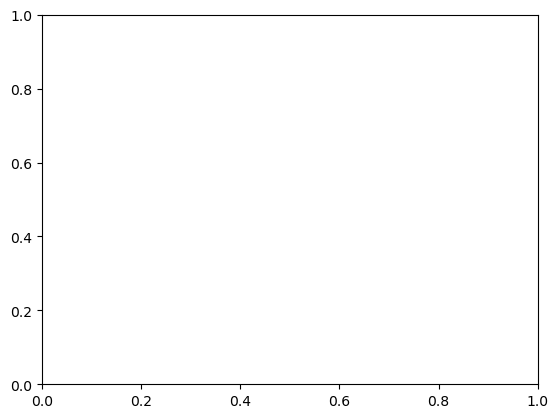

In [8]:
xs_over_time = jnp.array(Data['Positions'])
for i in range(t):
    plt.title('Particle positions at timestep '+str((i+1)*steps_per_snapshots*dt))
    plt.ylim([0,3*no_pseudoelectrons/len(grid)])
    plt.xlim([-box_size_x/2,box_size_x/2])
    plt.xlabel(r'$x/m$')
    plt.ylabel('No. of Particles')
    plt.hist(xs_over_time[i,no_pseudoelectrons:,0],jnp.linspace(-box_size_x/2,box_size_x/2,len(grid)+1),color='red',label='ions')
    #plt.hist(xs_over_time[i,no_pseudoelectrons:,0],jnp.linspace(-box_size_x/2,box_size_x/2,len(grid)+1),color='red',label='positrons')
    plt.hist(xs_over_time[i,:no_pseudoelectrons,0],jnp.linspace(-box_size_x/2,box_size_x/2,len(grid)+1),color='blue',label='electrons')
    plt.legend()
    plt.pause(0.1)
    plt.cla()

[ 51565456. -48433592.  51563800. ... -48435792.  51566120. -48434208.]


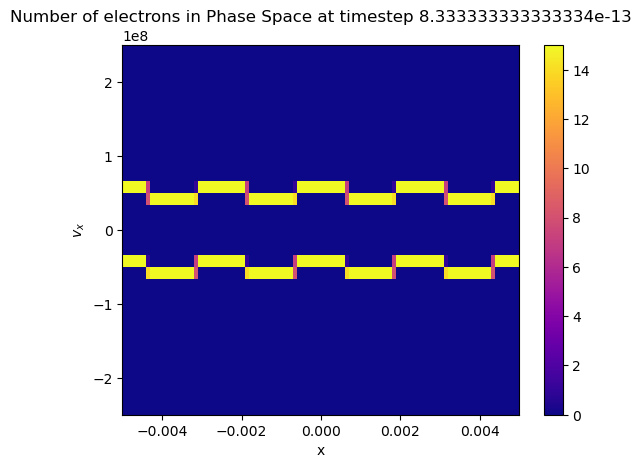

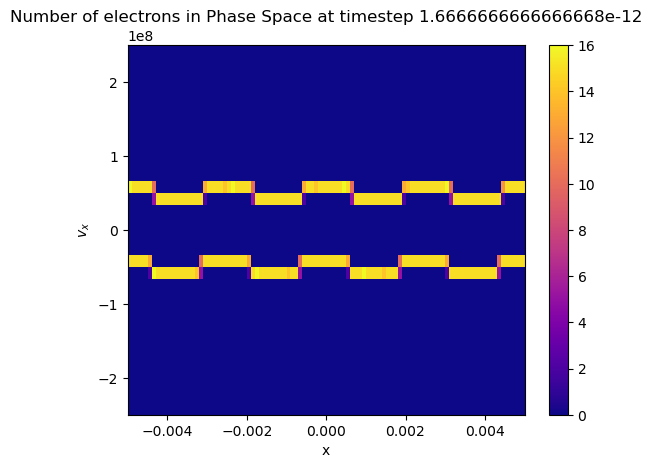

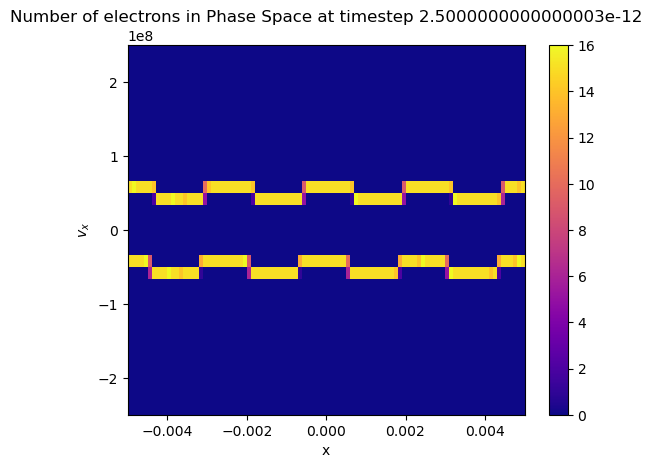

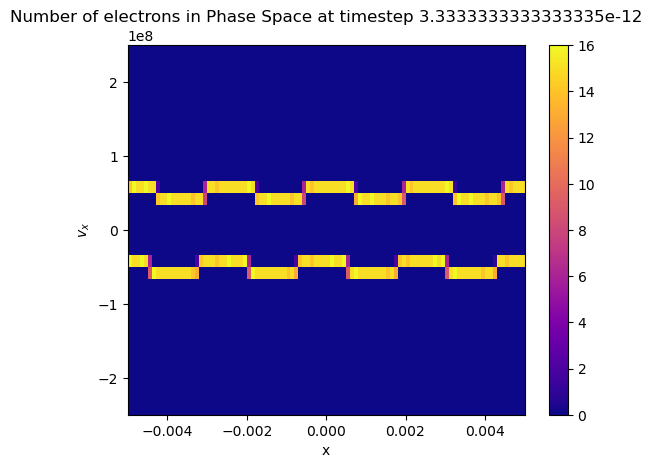

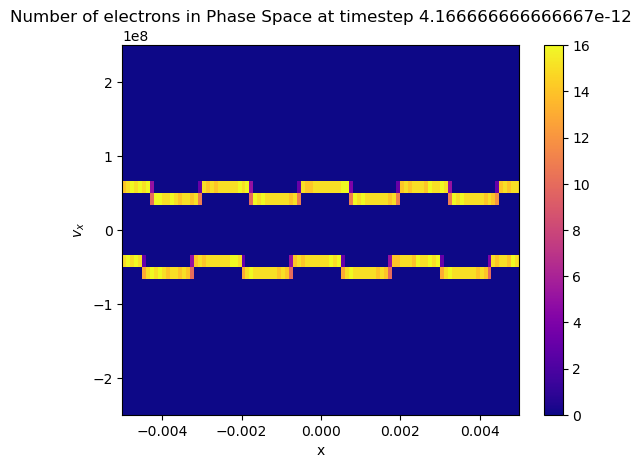

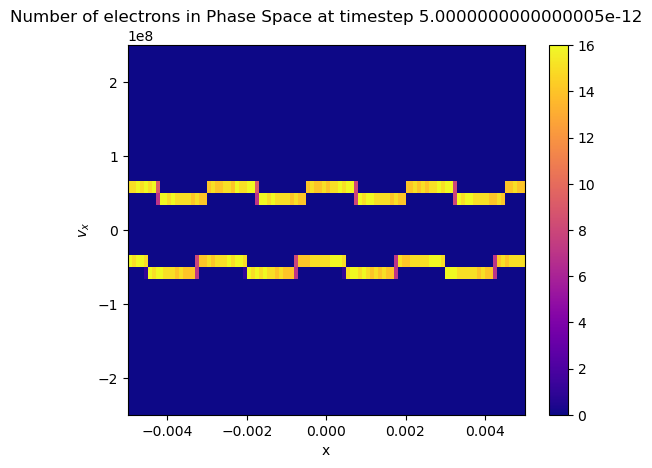

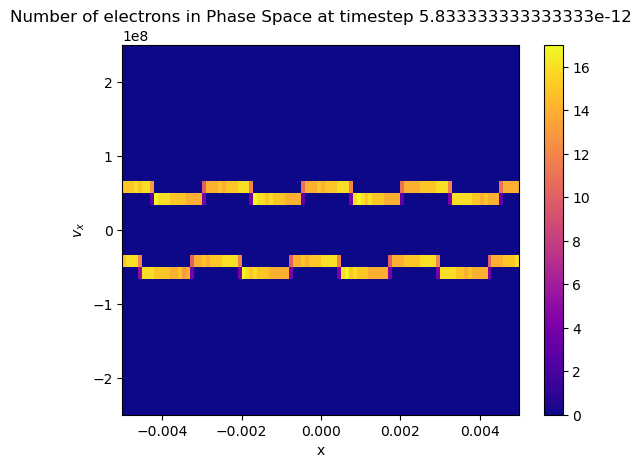

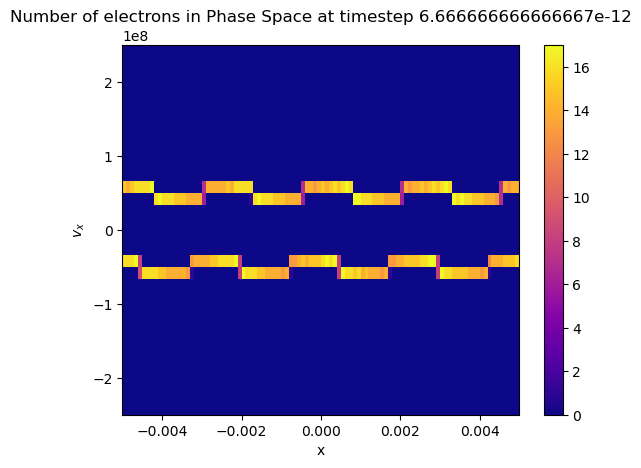

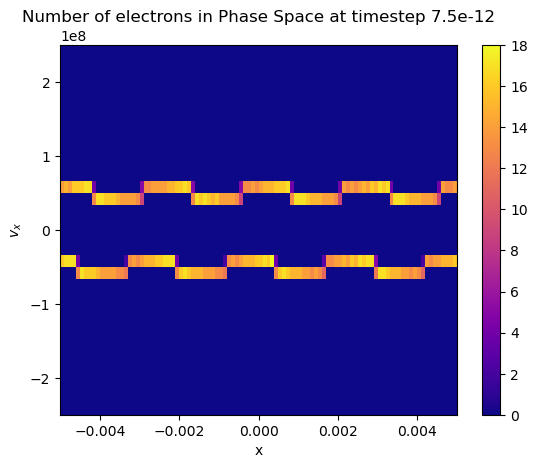

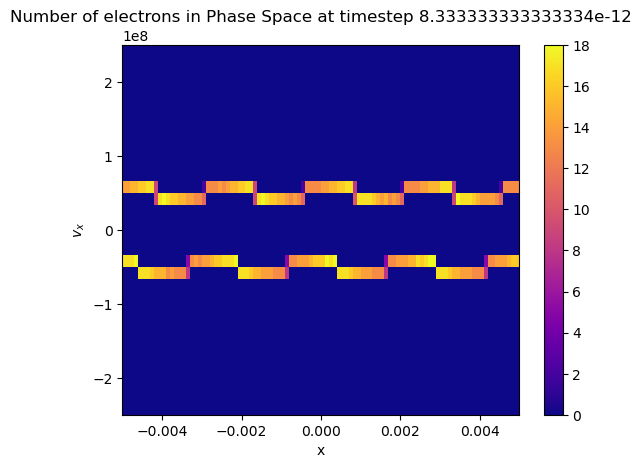

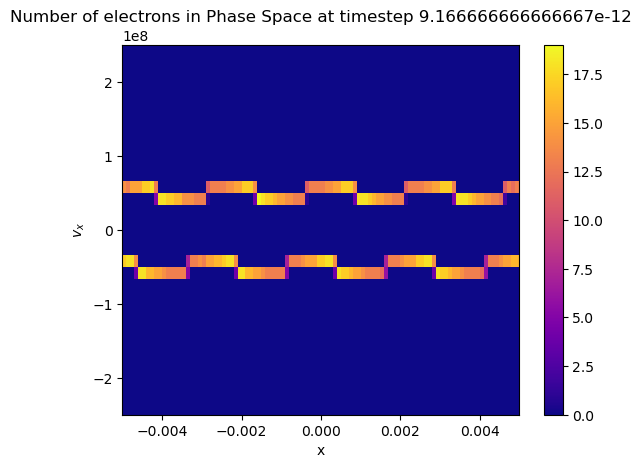

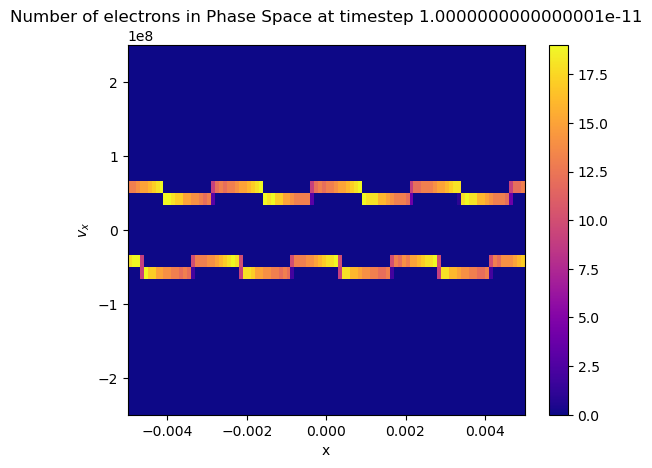

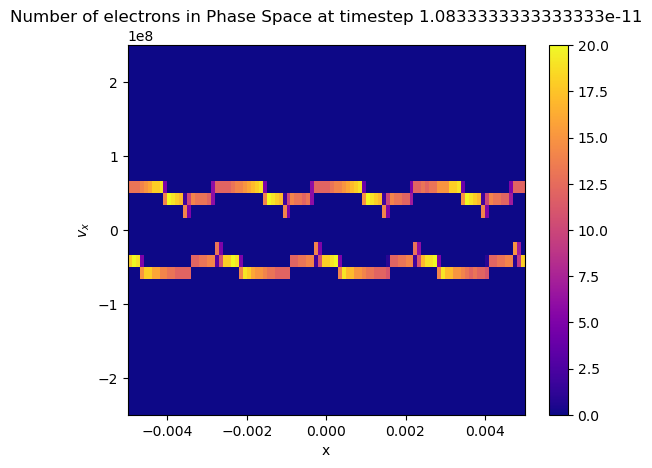

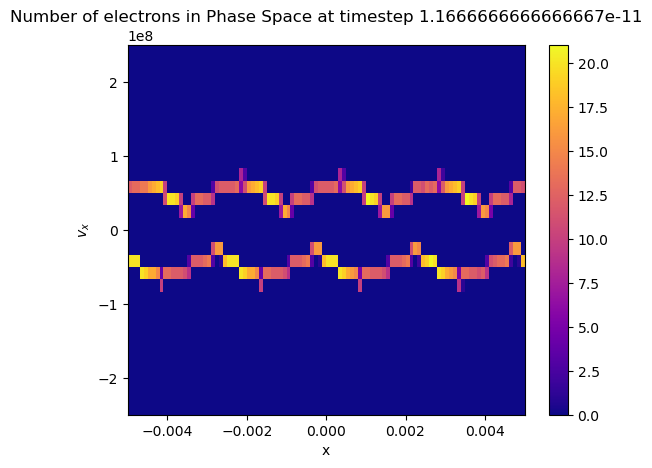

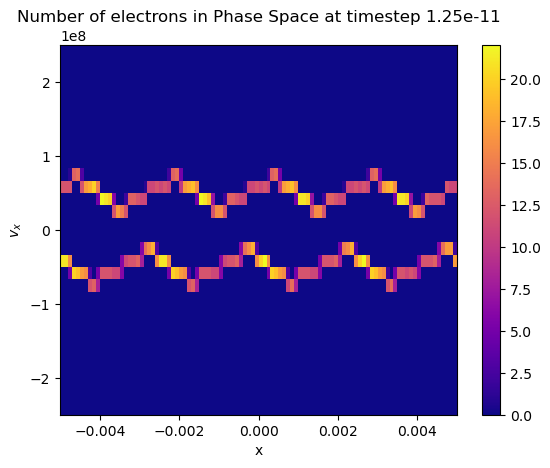

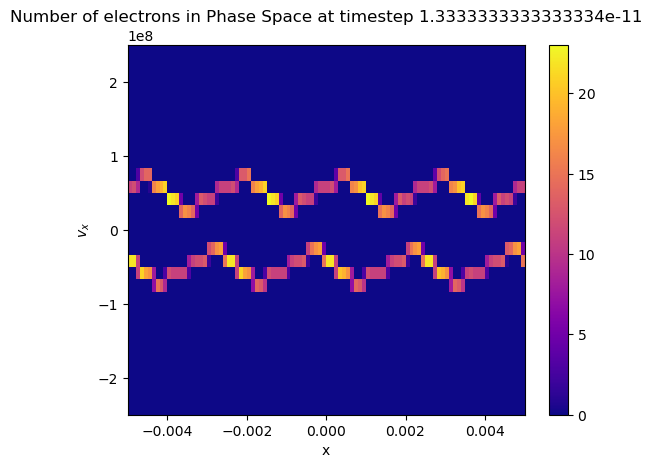

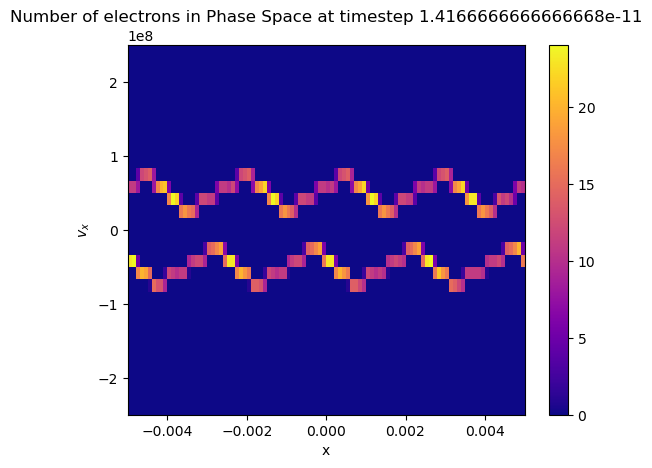

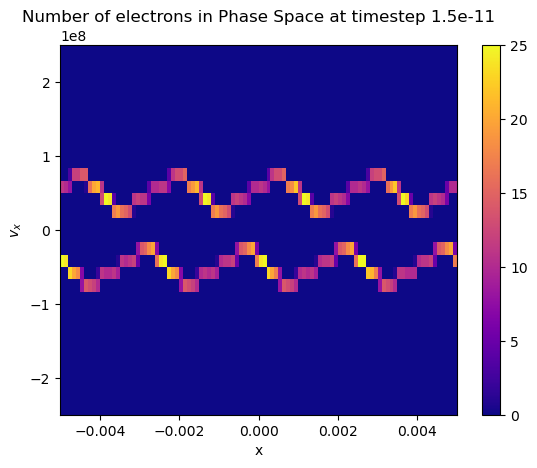

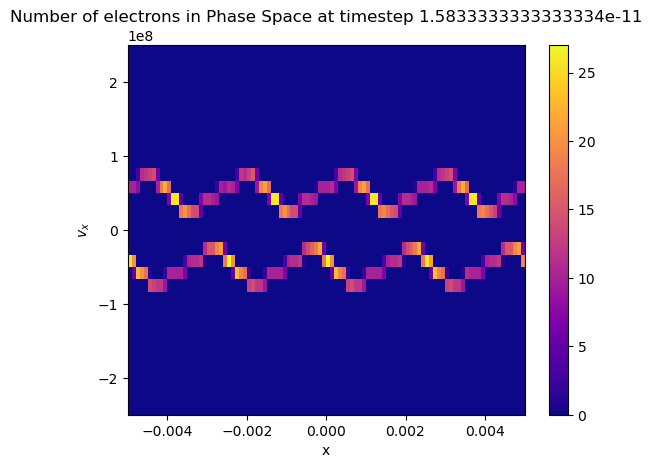

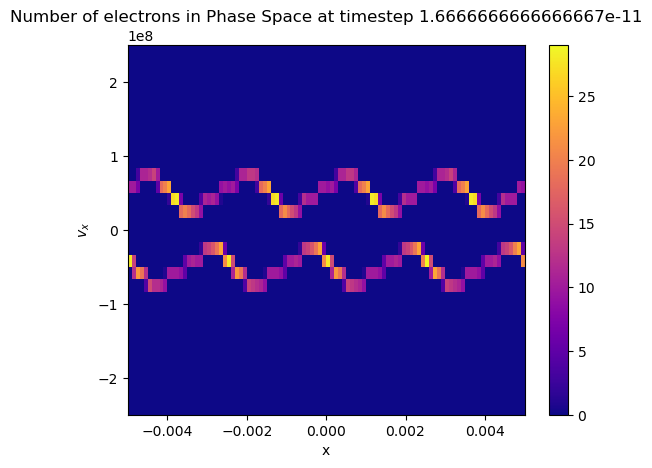

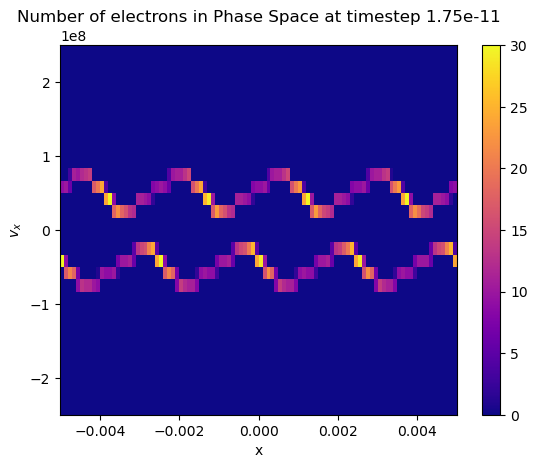

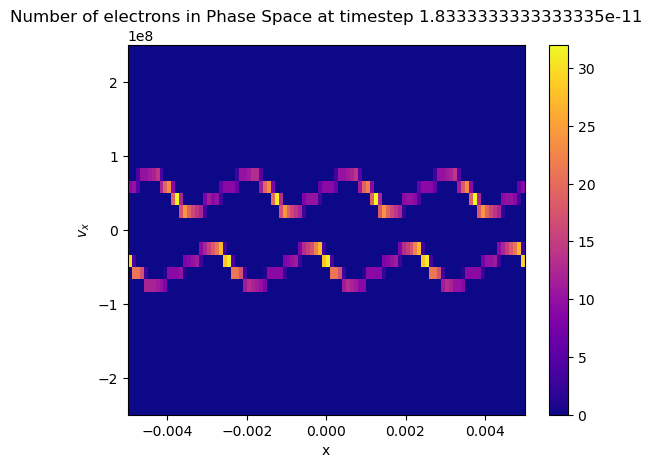

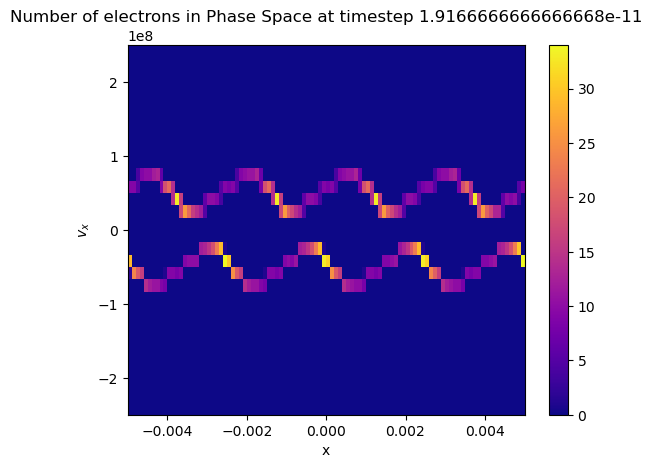

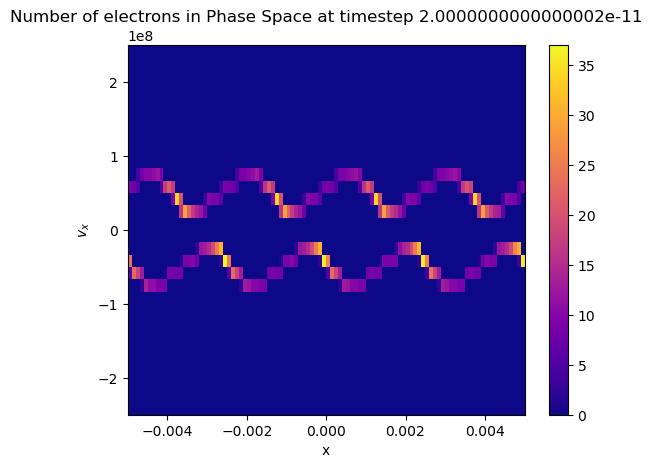

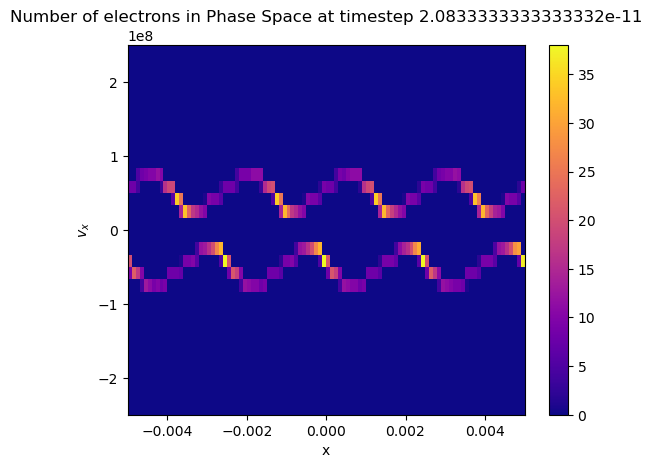

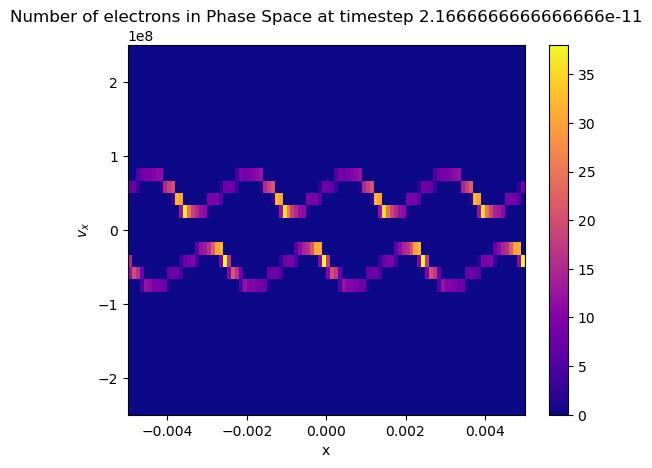

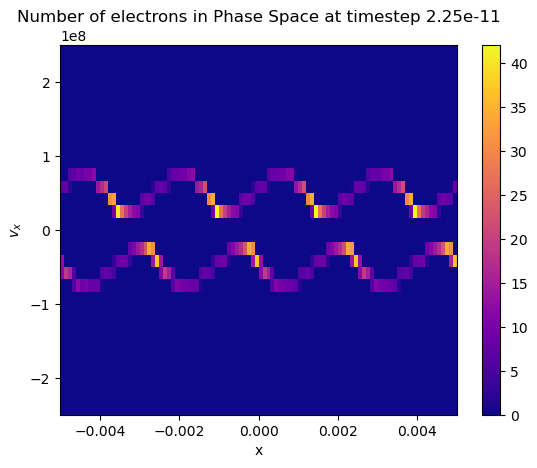

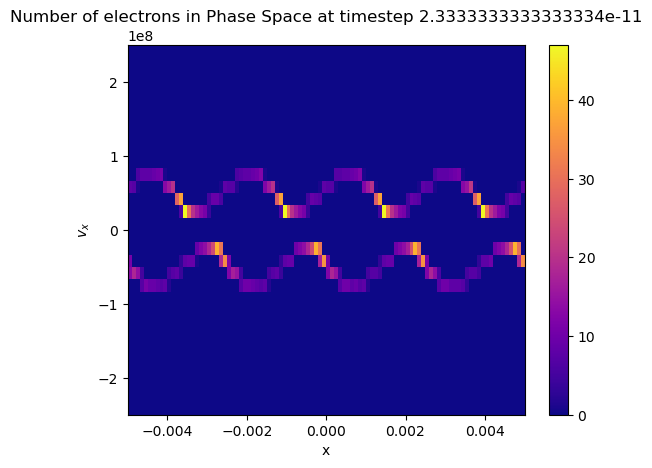

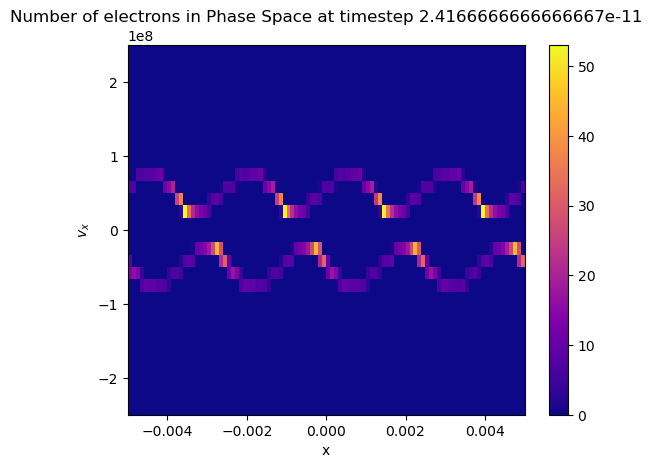

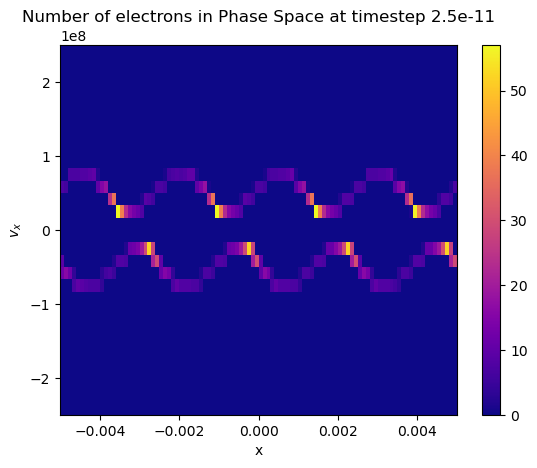

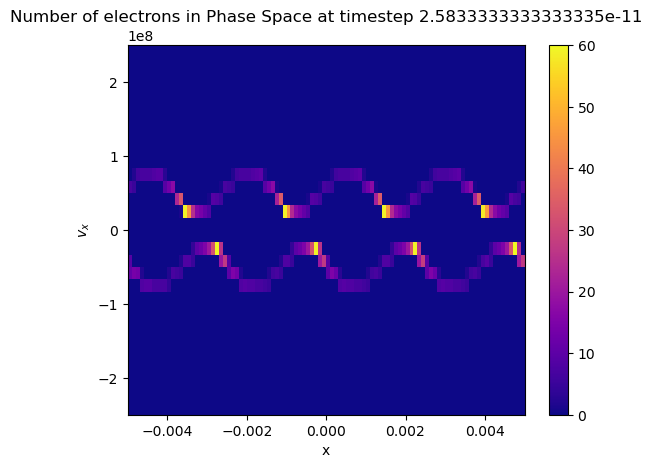

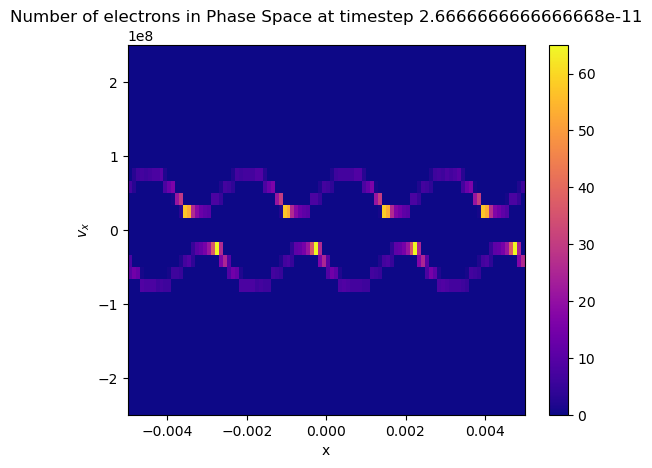

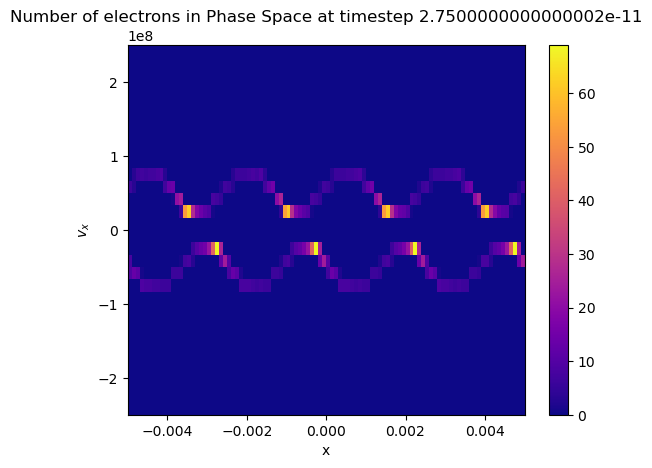

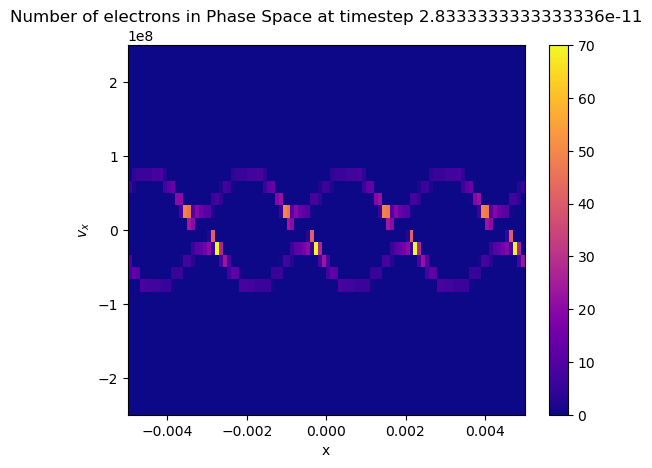

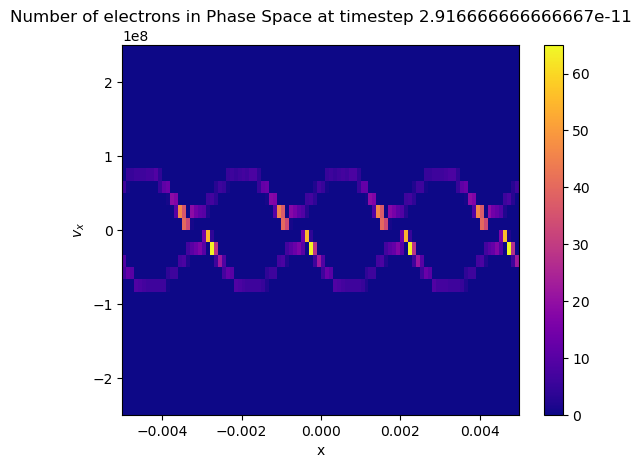

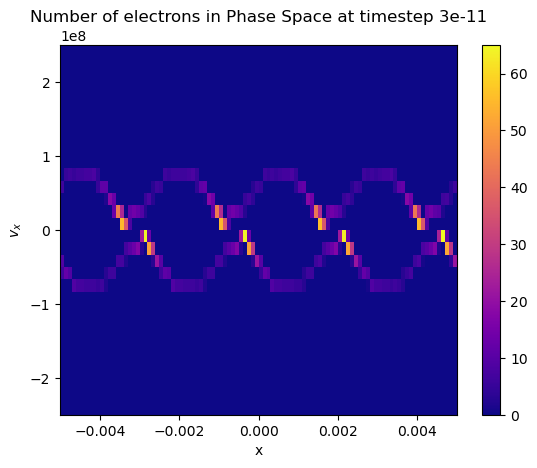

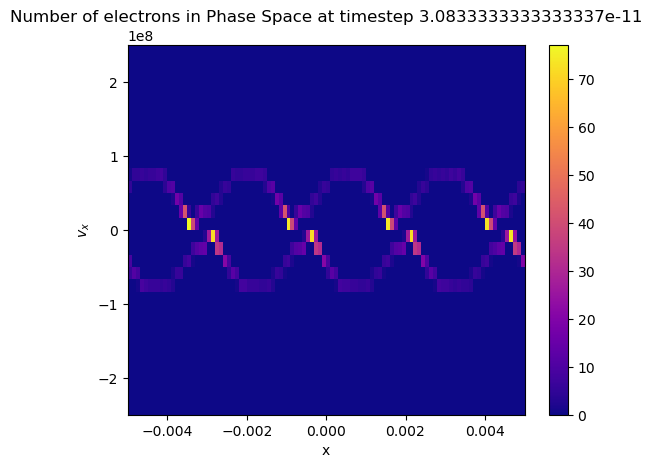

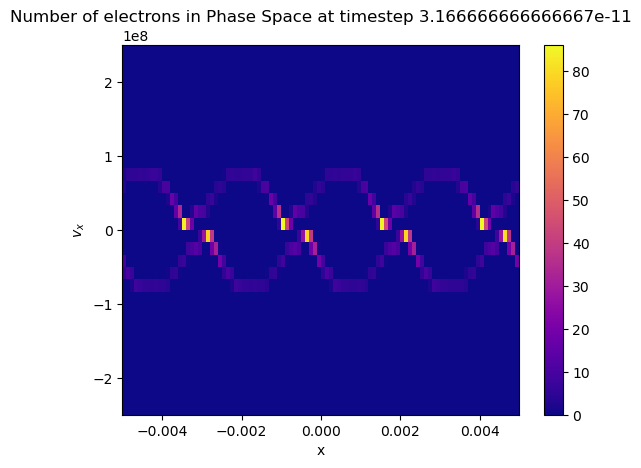

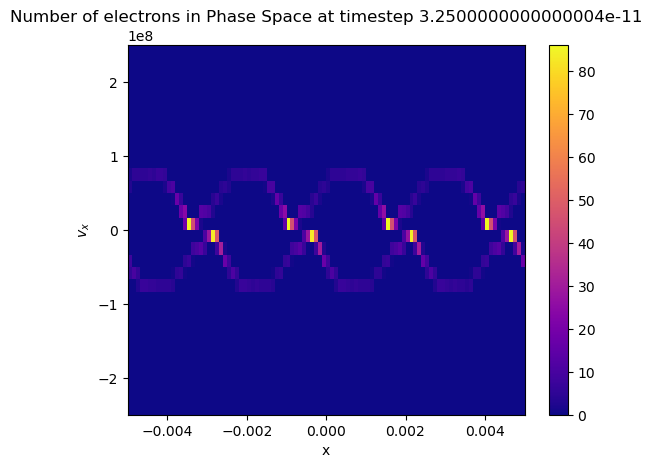

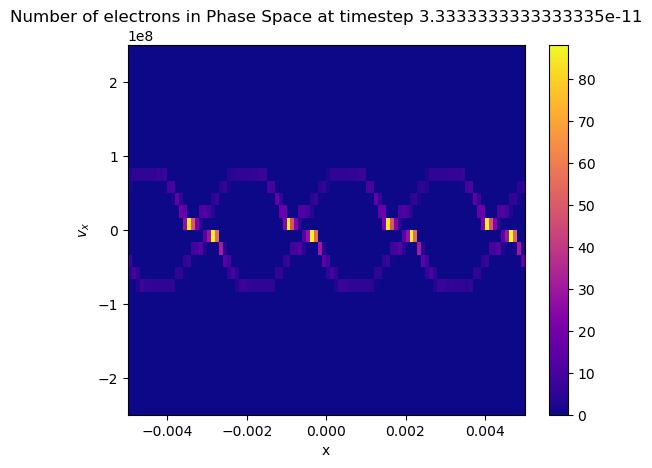

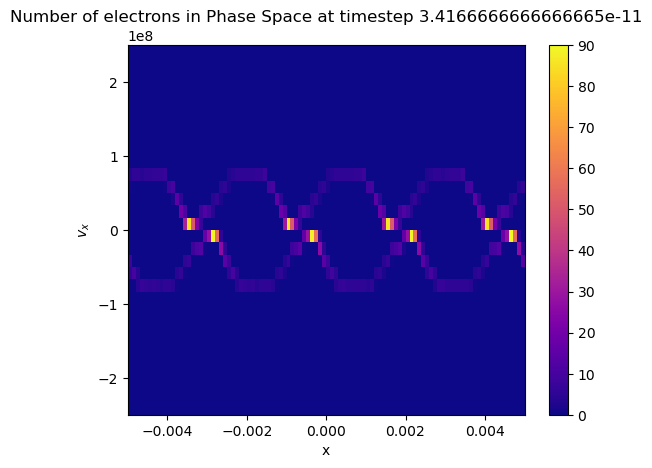

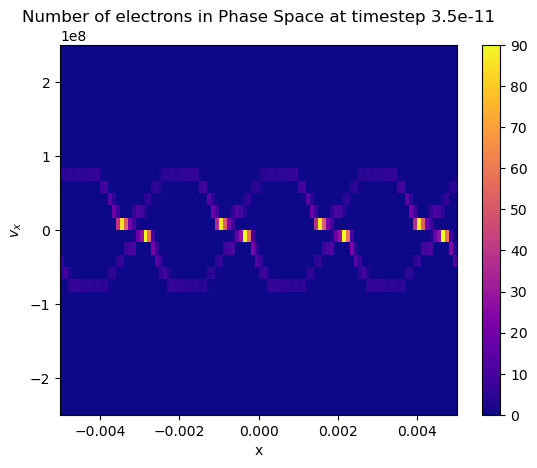

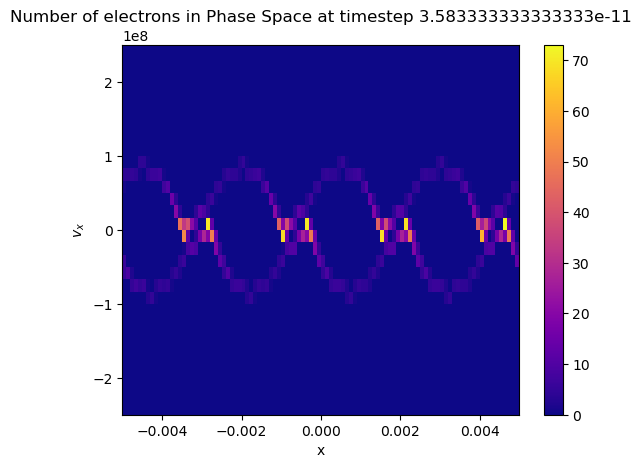

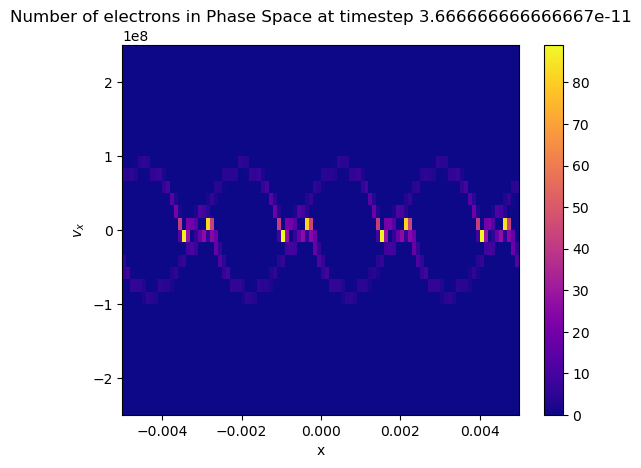

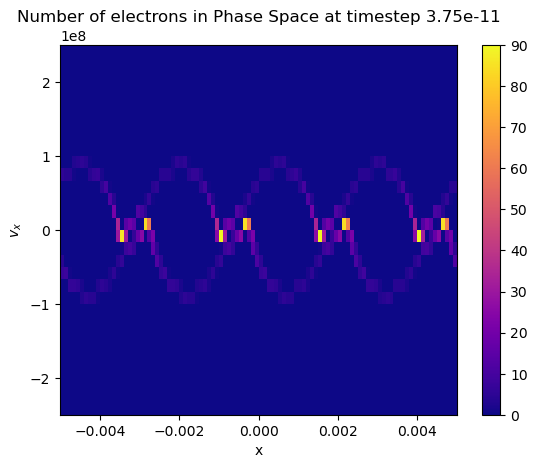

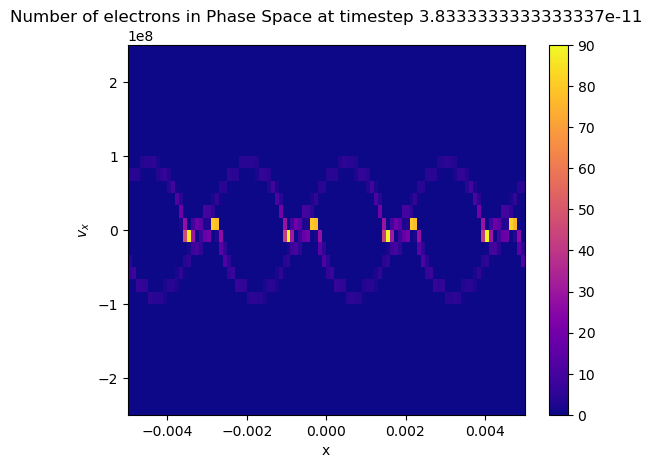

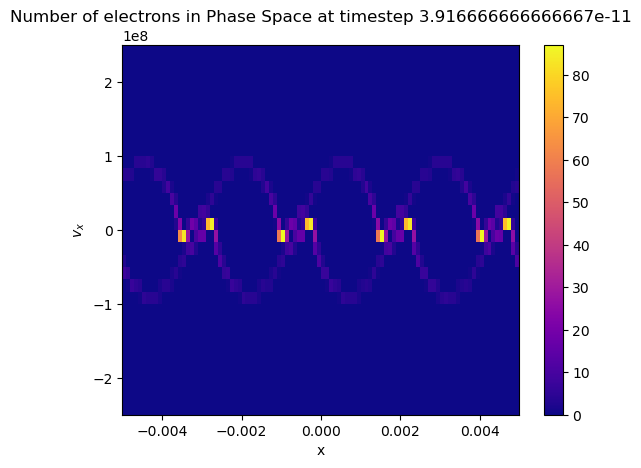

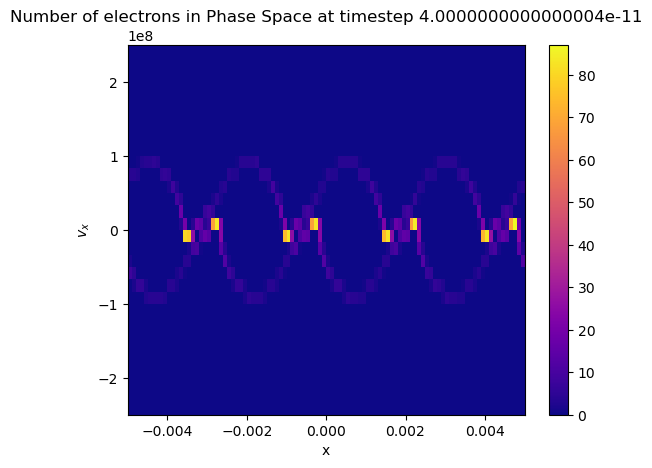

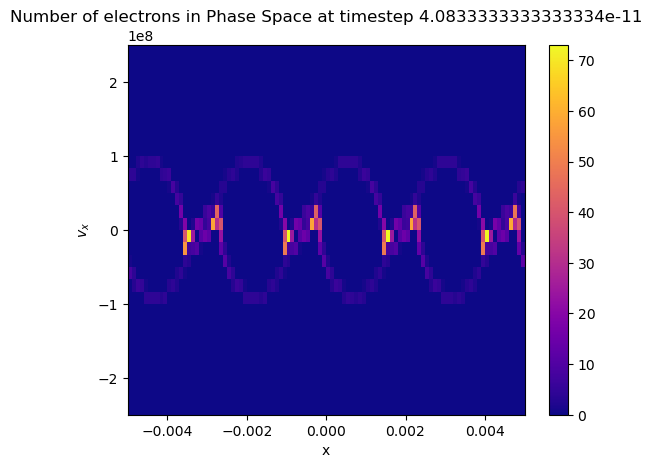

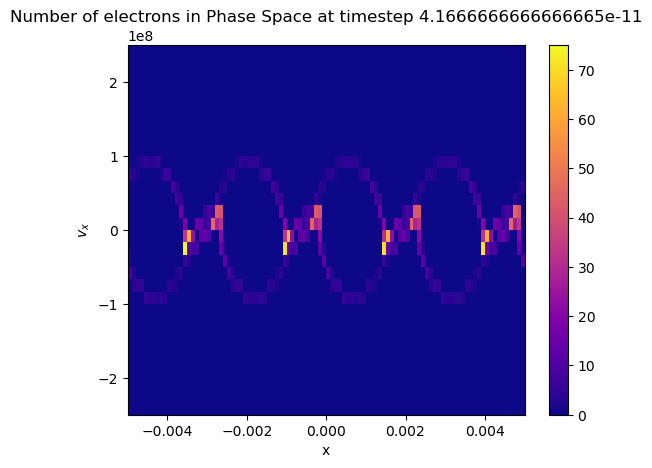

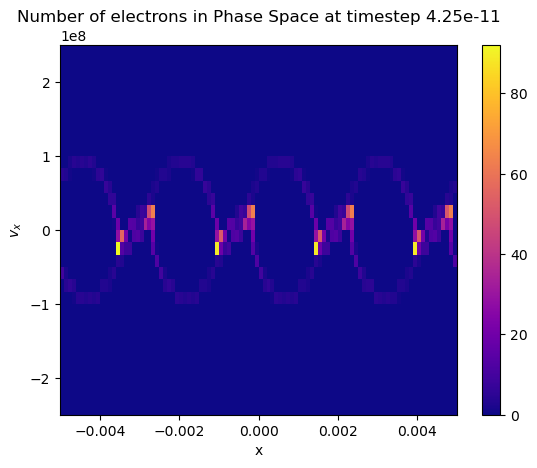

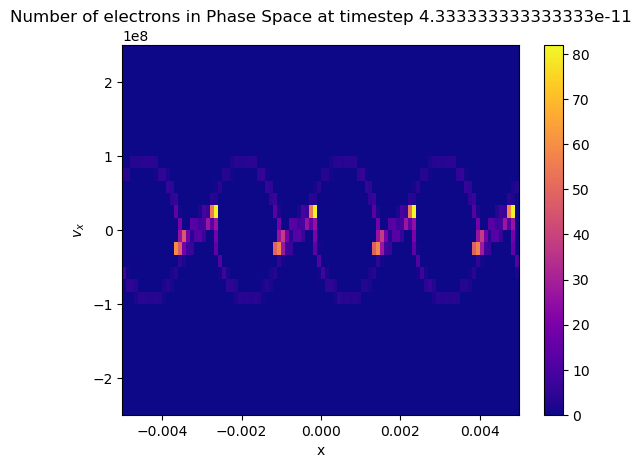

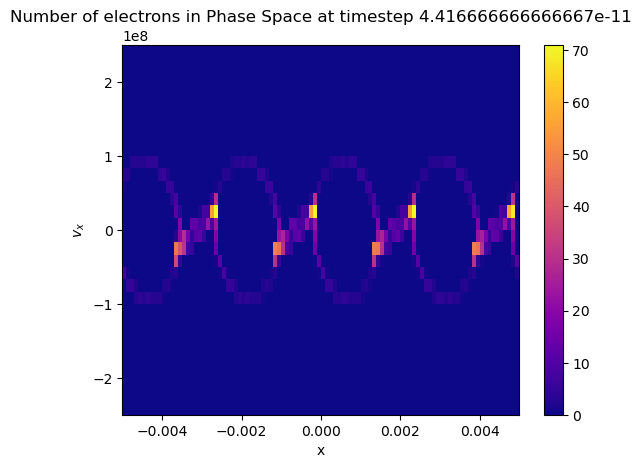

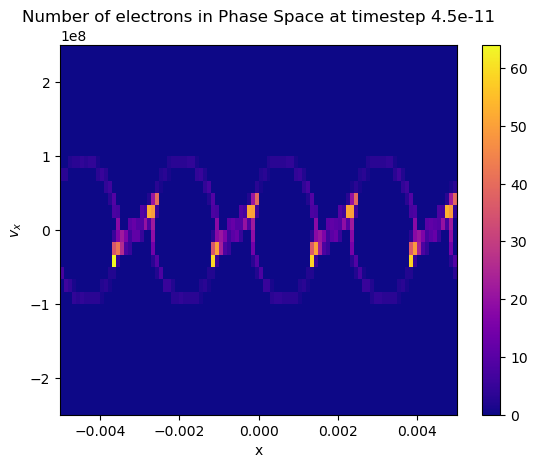

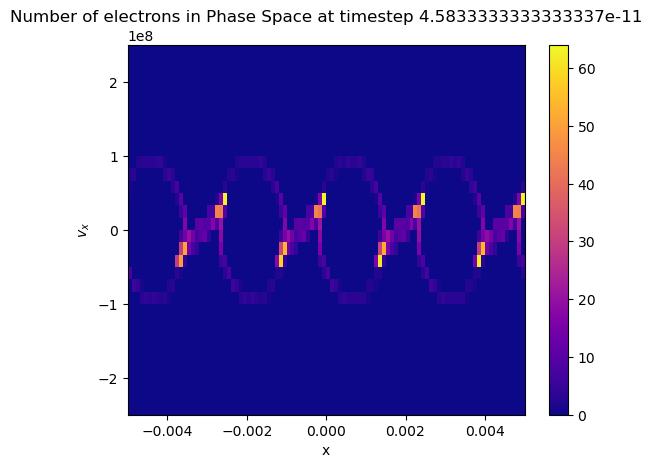

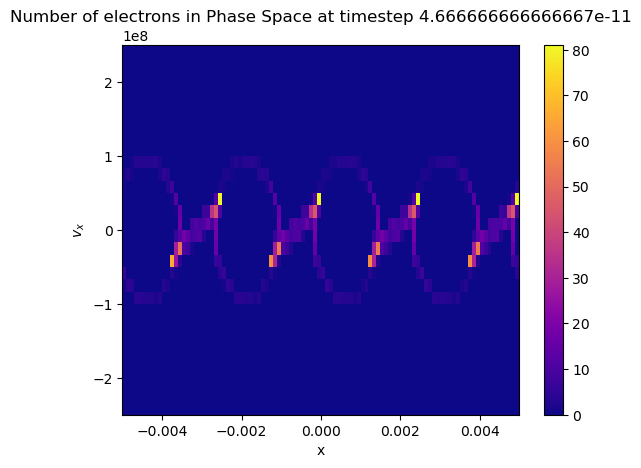

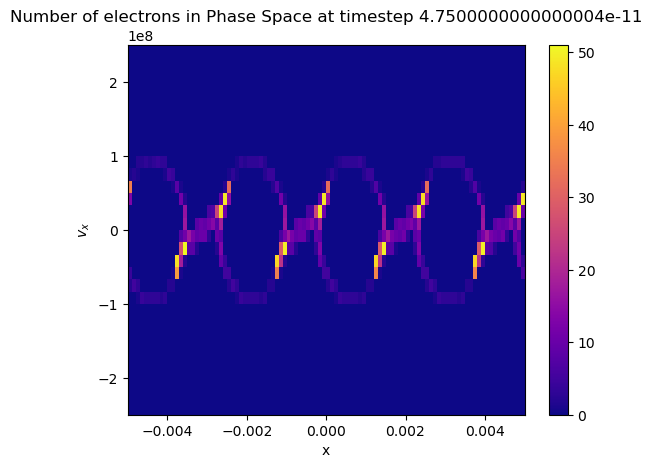

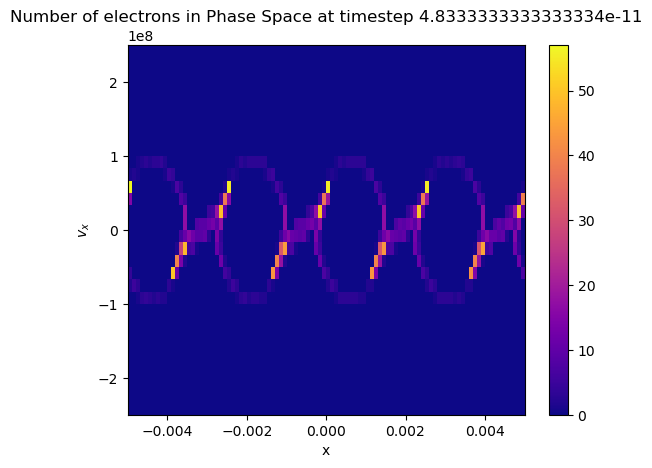

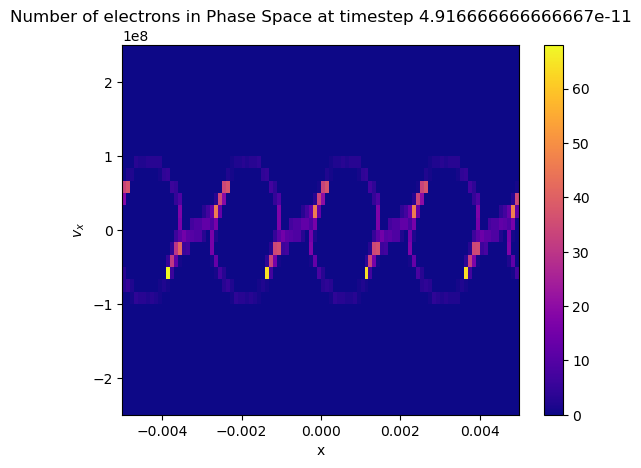

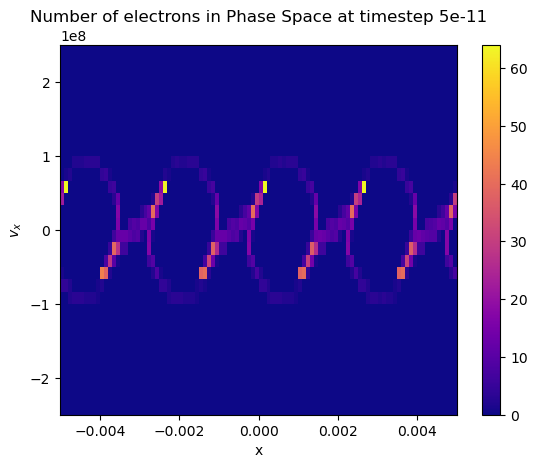

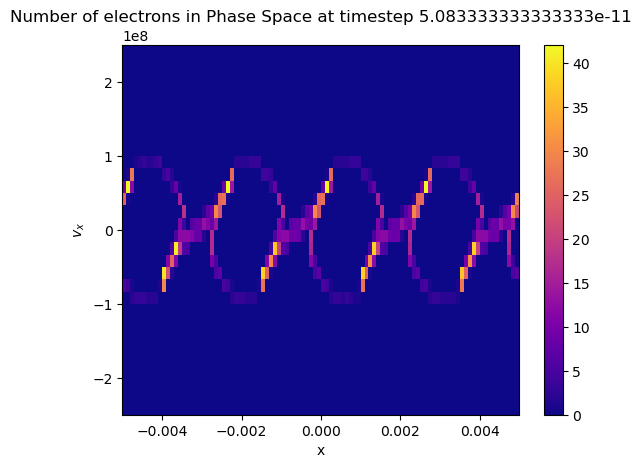

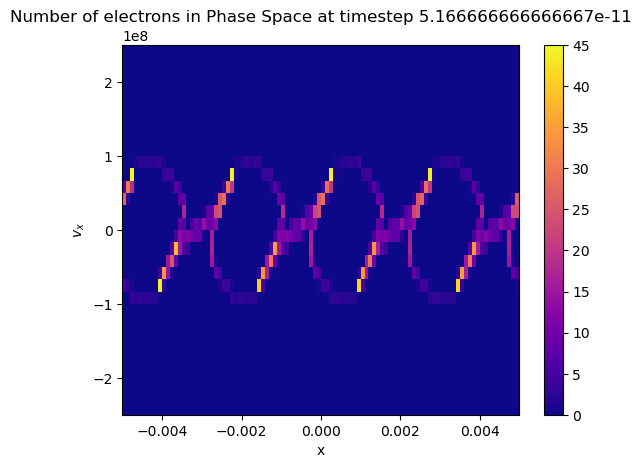

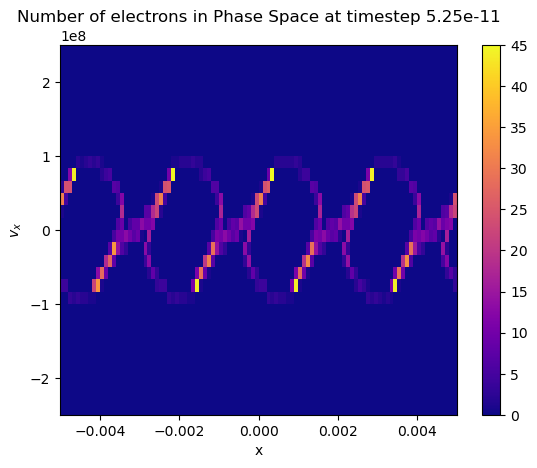

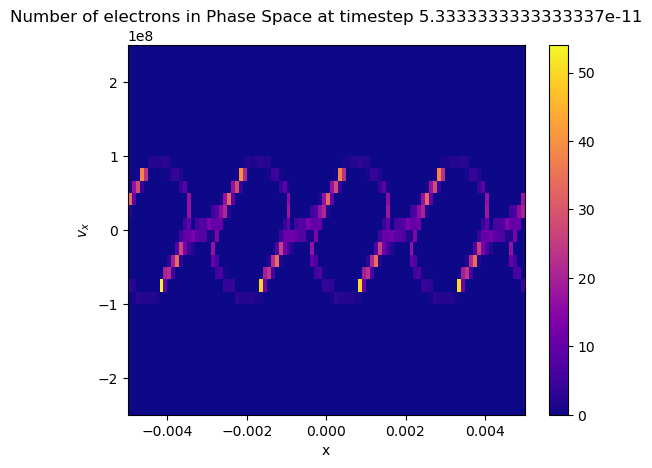

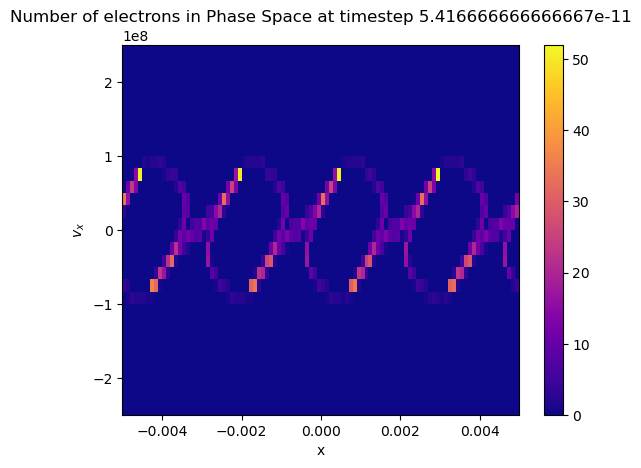

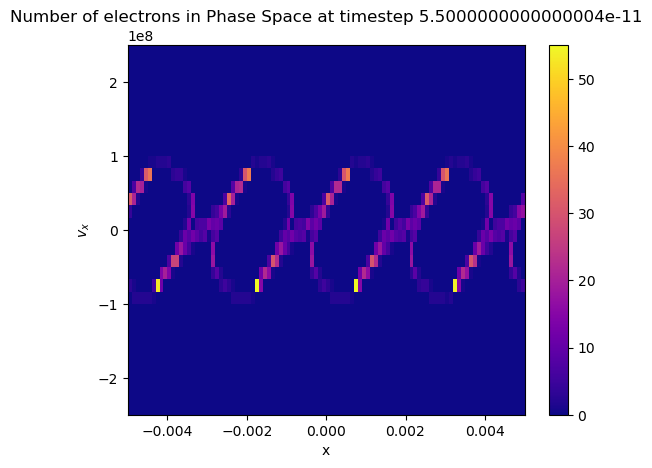

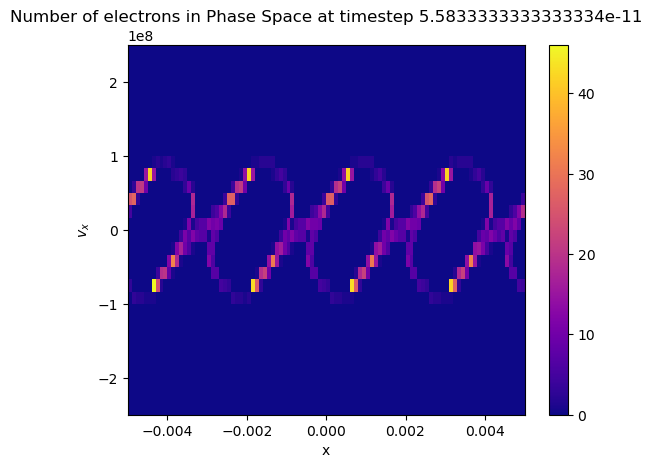

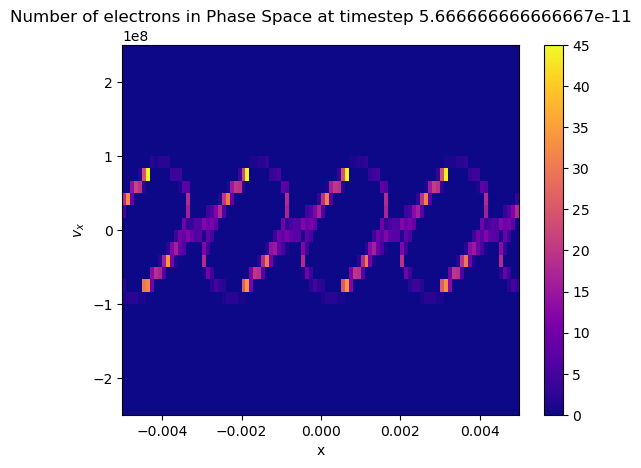

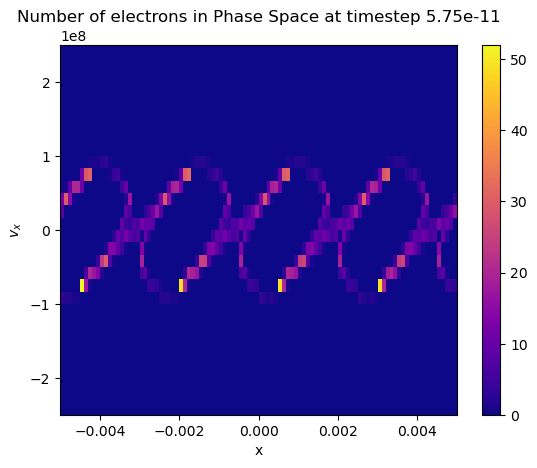

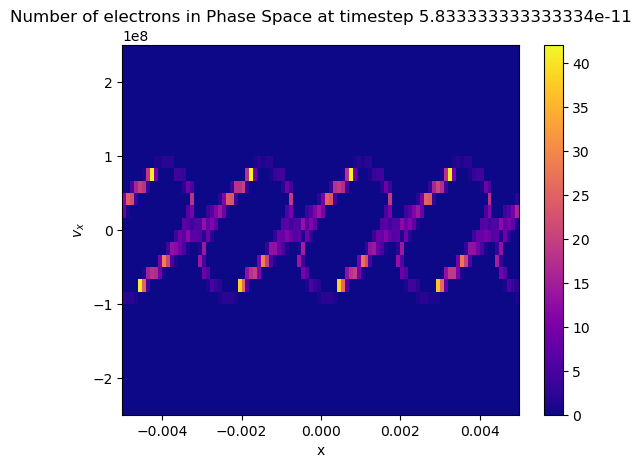

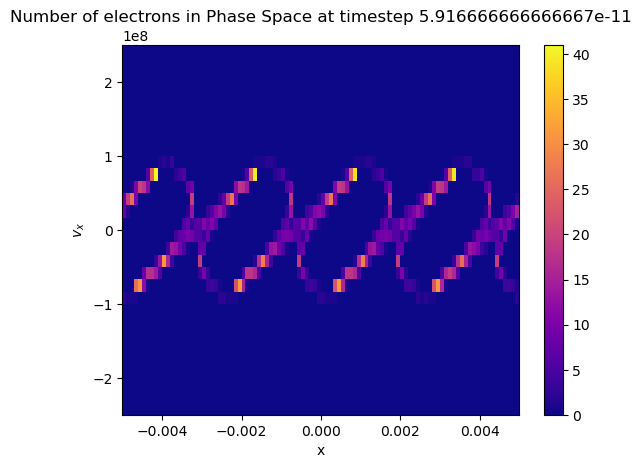

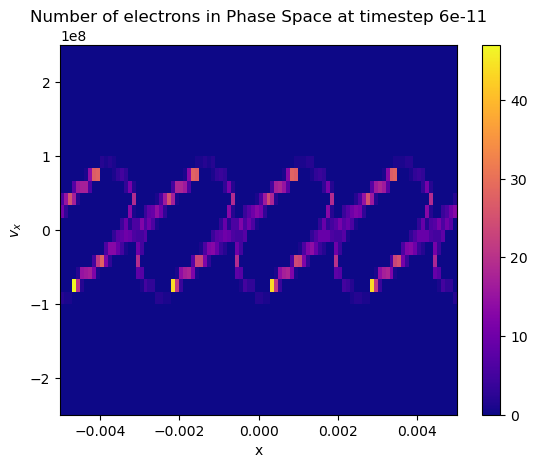

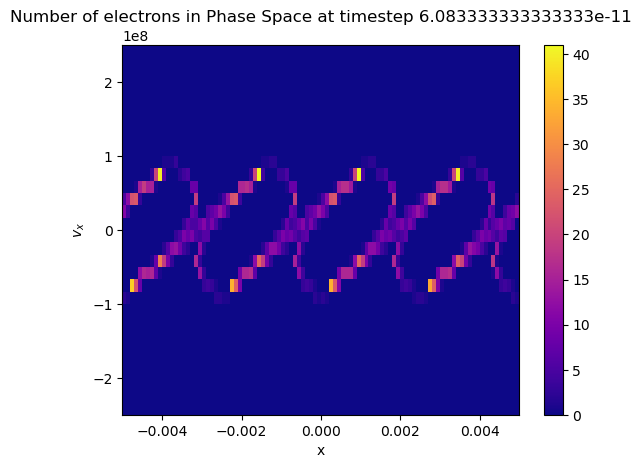

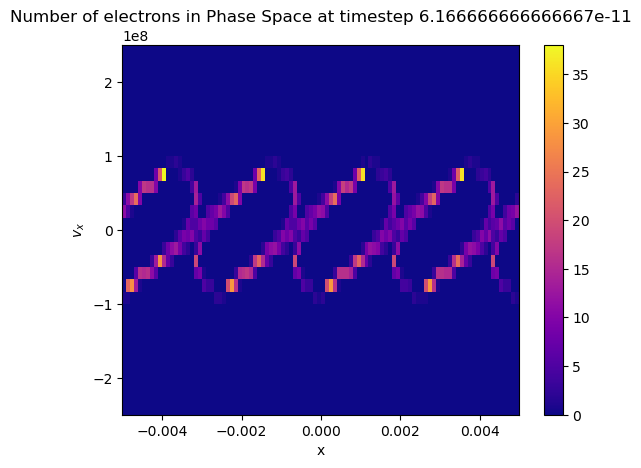

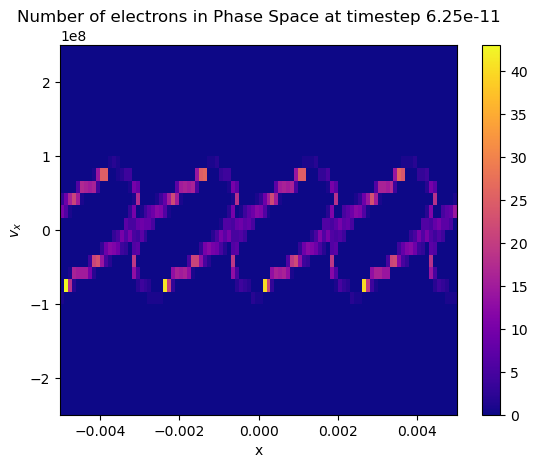

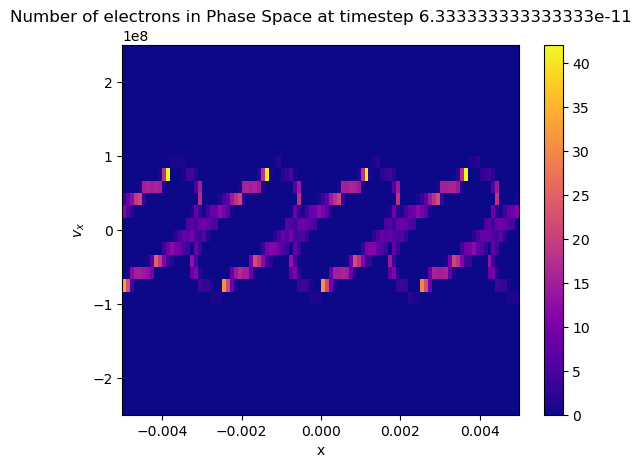

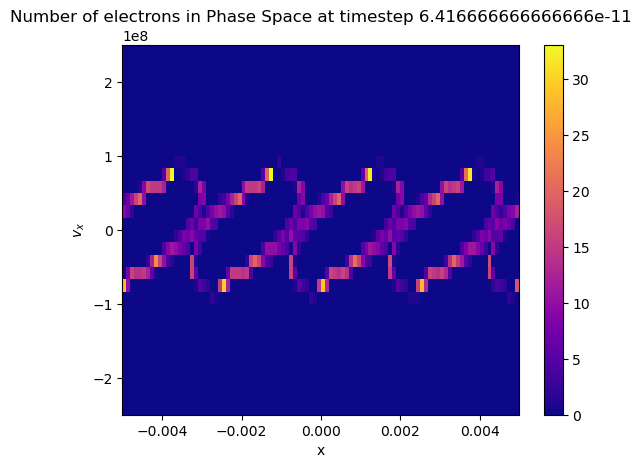

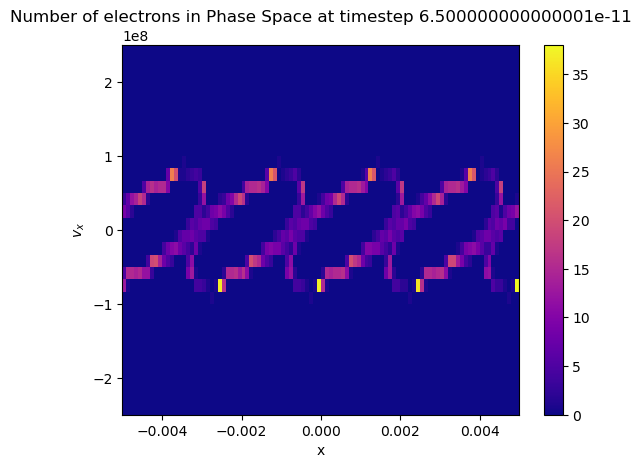

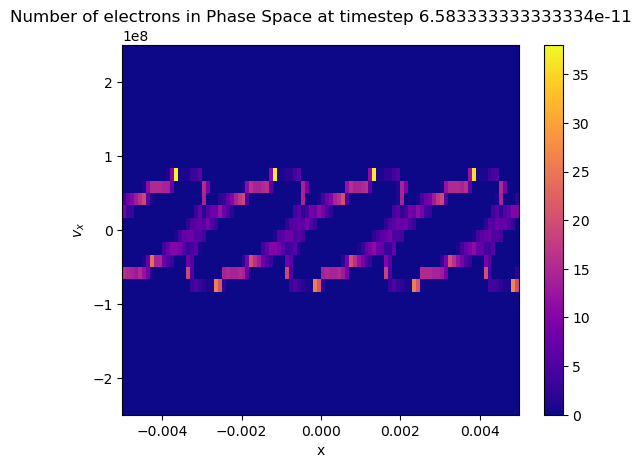

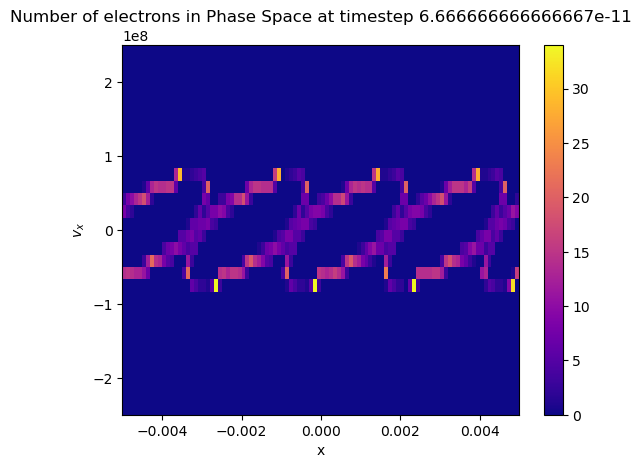

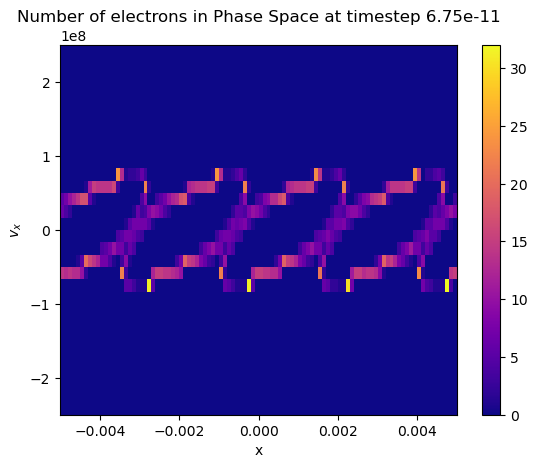

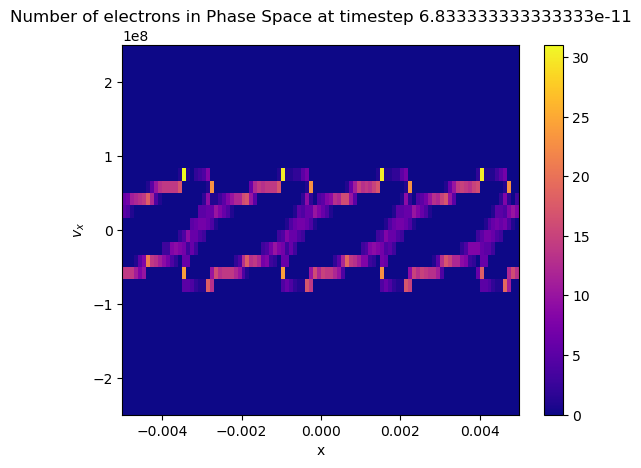

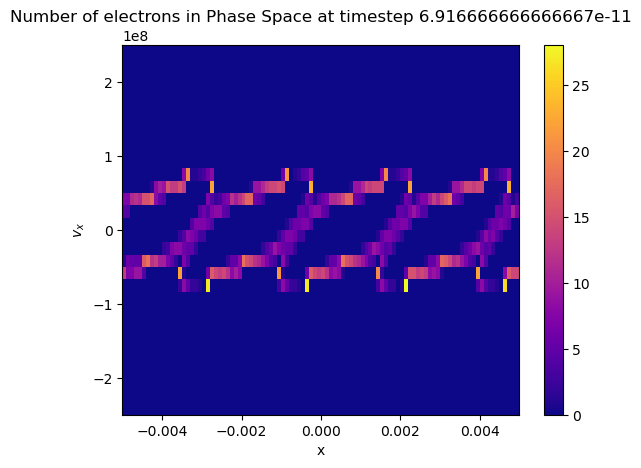

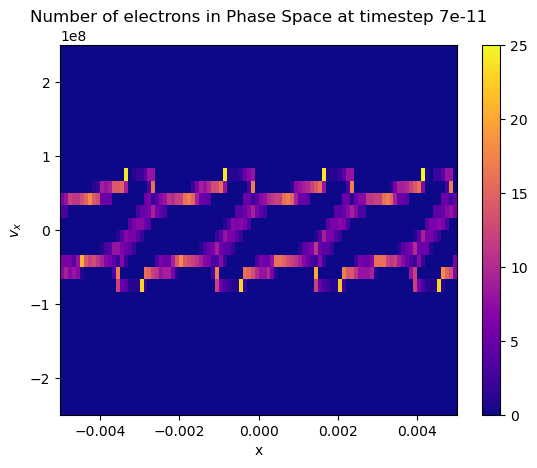

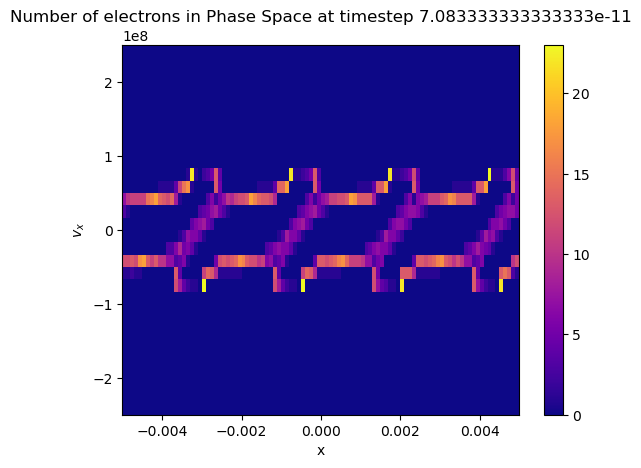

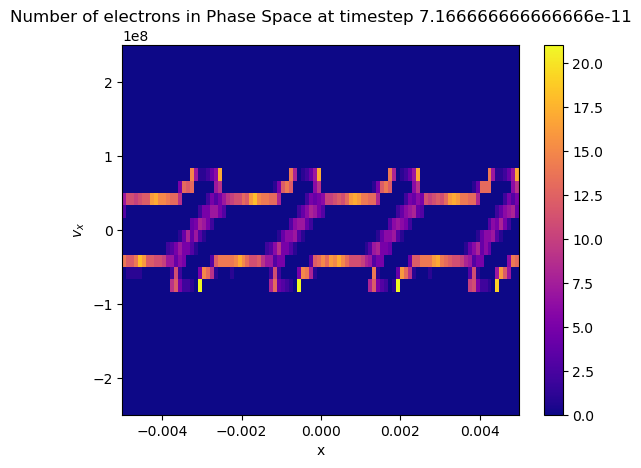

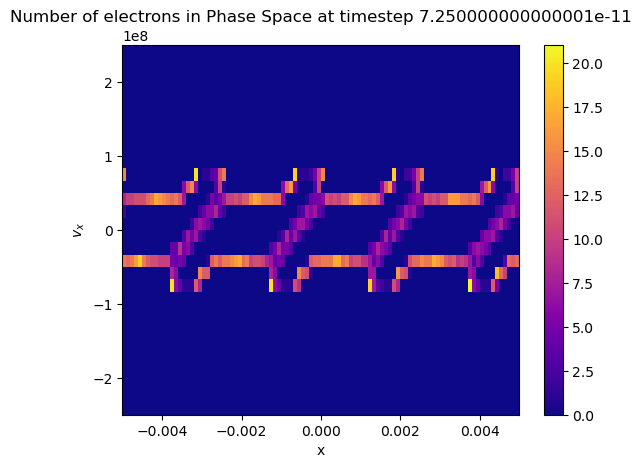

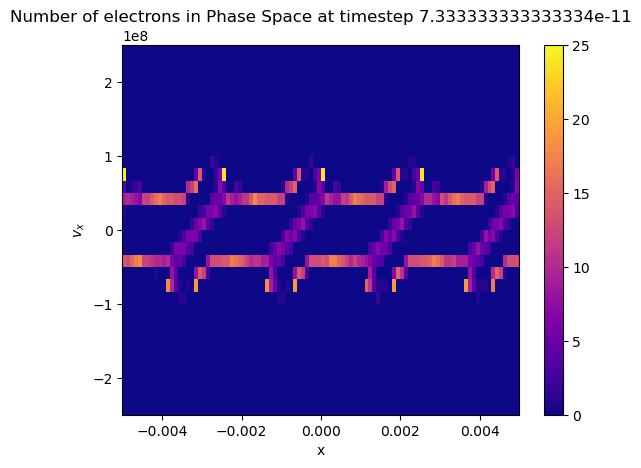

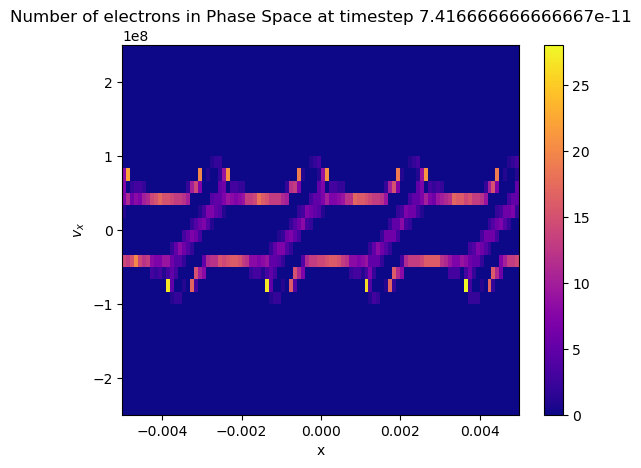

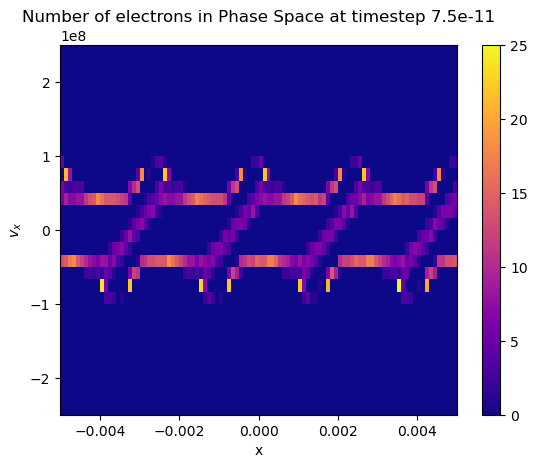

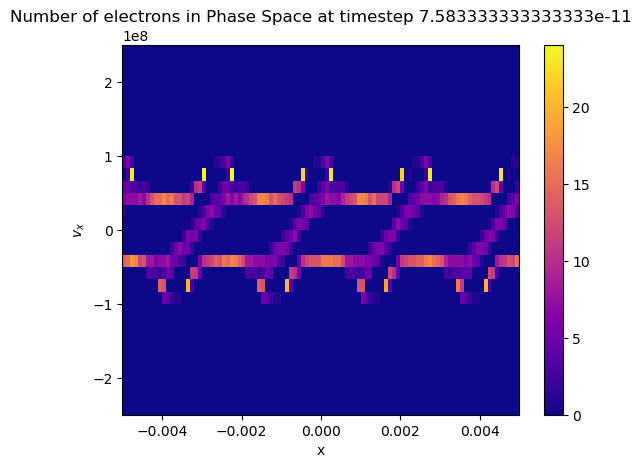

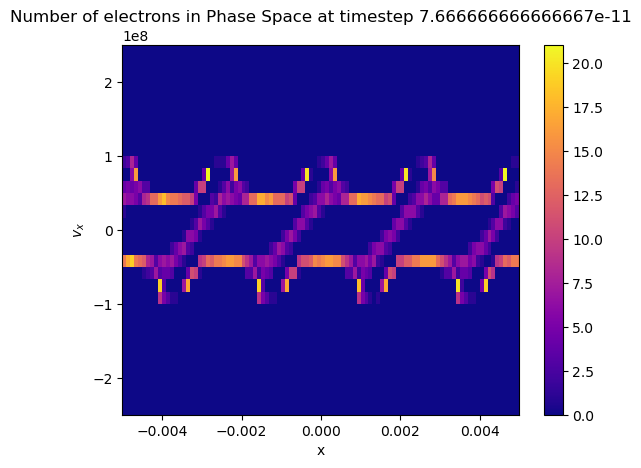

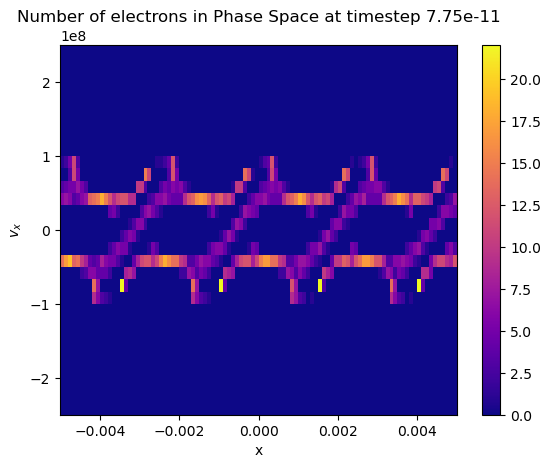

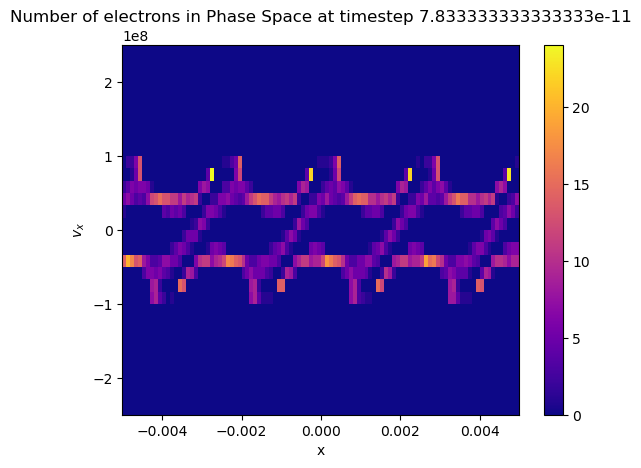

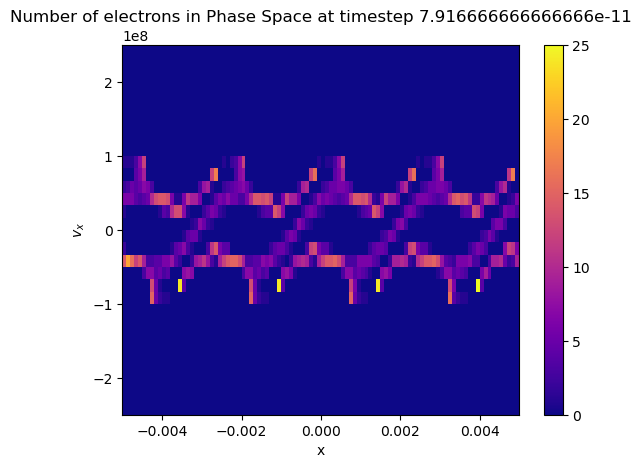

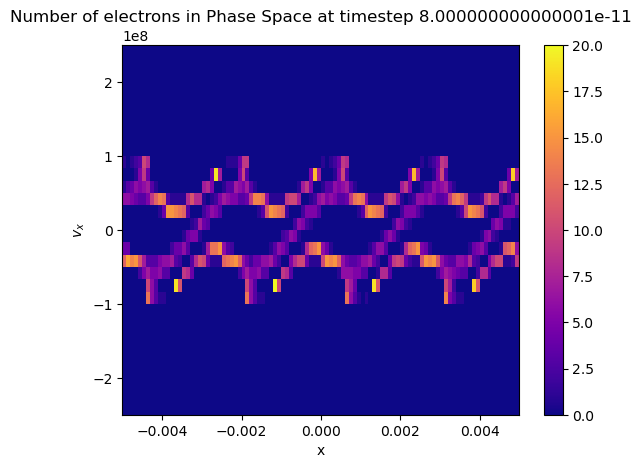

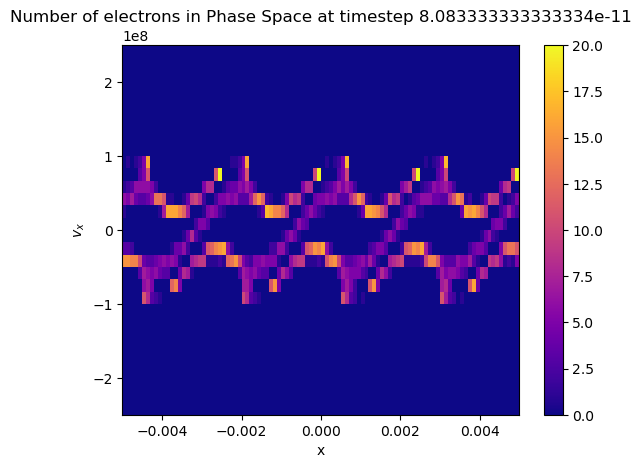

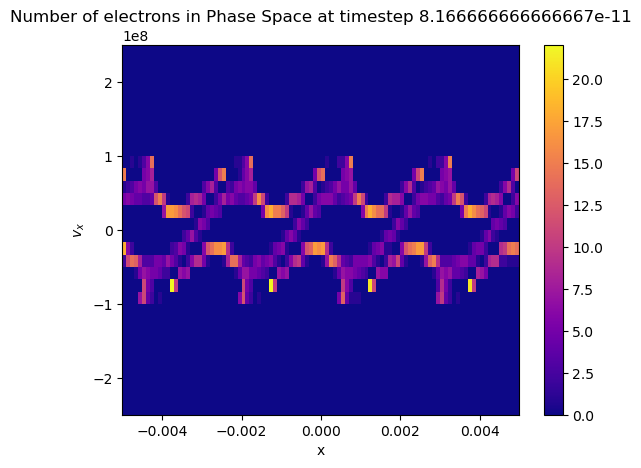

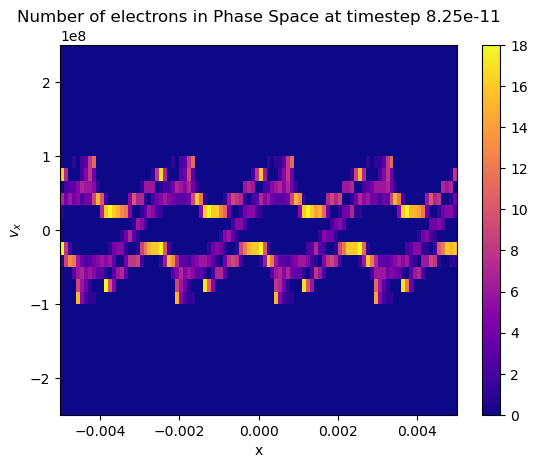

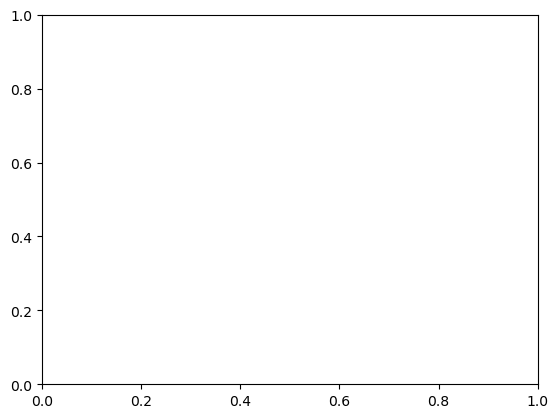

In [10]:
xs_over_time = jnp.array(Data['Positions'])
vs_over_time = jnp.array(Data['Velocities'])
print((vs_over_time[0,:no_pseudoelectrons,0]))
for i in range(t):
    plt.title('Number of electrons in Phase Space at timestep '+str((i+1)*steps_per_snapshots*dt))
    plt.hist2d(xs_over_time[i,:no_pseudoelectrons,0],vs_over_time[i,:no_pseudoelectrons,0],jnp.array([len(grid),30]),[[-box_size_x/2,box_size_x/2],[-5*v0,5*v0]],cmap='plasma')
    plt.xlabel('x')
    plt.ylabel(r'$v_x$')
    cb = plt.colorbar()
    plt.pause(0.01)
    cb.remove()
    plt.cla()